# Data Preparation - Dataset de Sepsis
## CRISP-DM Fase 3: Preparação dos Dados

**Objetivo da Fase:**
* Transformar dados brutos em formato adequado para modelagem
* Implementar estratégias de limpeza e tratamento baseadas nos insights da EDA
* Criar features derivadas com relevância clínica
* Preparar datasets finais para algoritmos de machine learning

**Baseado nos Insights da EDA:**
* 37/41 variáveis apresentam missing values (68.37% do dataset)
* 27 variáveis com >80% missing (candidatas à remoção)
* Dataset altamente desbalanceado: 98.2% não-sepsis vs 1.8% sepsis
* Estrutura temporal importante: risco aumenta após 100h na UTI
* Variáveis categóricas bem definidas: Gender, Unit1, Unit2

**Tarefas CRISP-DM a serem executadas:**
1. **Seleção dos Dados**: Escolher variáveis mais relevantes
2. **Limpeza dos Dados**: Tratar inconsistências e valores ausentes  
3. **Construção dos Dados**: Criar features derivadas e engenharia
4. **Integração dos Dados**: Combinar fontes (não aplicável aqui)
5. **Formatação dos Dados**: Preparar formato final para modelagem

## Configuração do Ambiente Google Colab

Para funcionar no Google Colab, é necessário criar um atalho do diretório [MDA](https://drive.google.com/drive/u/0/folders/1YFieuvYMGx198h_CKCULdfv7IKRwDuMp) no seu próprio Drive e então rodar os dois comandos abaixo e conceder permissão ao seu drive quando rodar a célula logo abaixo.

[Link](https://towardsdatascience.com/simplify-file-sharing-44bde79a8a18/) detalhando como funciona

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# modificar para o diretorio que contém os dados de teste e treino
%cd /content/drive/MyDrive/MDA/Train\ and\ test\ data\ -\ Proj\ DM/

!ls

## 1. Importação das Bibliotecas

Importação de todas as bibliotecas necessárias para preparação dos dados, incluindo bibliotecas específicas para pré-processamento, feature engineering e balanceamento de classes.

In [ ]:
# Bibliotecas essenciais para manipulação de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configurações gerais
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Bibliotecas importadas com sucesso")

## 2. Carregamento dos Dados e Insights da EDA

Carregamento dos datasets de treino e teste, seguido da documentação dos principais insights obtidos na análise exploratória que guiarão as decisões de preparação.

In [4]:
train_df = pd.read_csv('dataset_sepsis_train.csv')

# Separar features e target
X_train = train_df.drop('SepsisLabel', axis=1)
y_train = train_df['SepsisLabel']

# Forma final
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")

# Distribuição das classes no treino
print(y_train.value_counts(normalize=True))

X_train: (1241768, 41) | y_train: (1241768,)
SepsisLabel
0.0    0.982015
1.0    0.017985
Name: proportion, dtype: float64


## 3. TAREFA 1: Seleção dos Dados

**Objetivo:** Escolher as variáveis mais relevantes para o modelo de mineração, removendo features com baixo potencial preditivo ou problemas graves de qualidade.

**Critérios de seleção:**
* Relevância clínica para detecção de sepsis
* Percentual de missing values aceitável
* Separabilidade entre classes (baseada na EDA)

### 3.1 Mapeamento de Variáveis com Excesso de Missing Values para Remoção

Vamos refazer a análise, mais objetiva e breve, das variáveis com >60% missing values para decidir quais manter, tratar ou remover baseado no critério de separabilidade de classes

In [5]:

# Identificar variáveis com >60% missing
high_missing_vars = []
for col in X_train.select_dtypes(include=[np.number]).columns:
    missing_pct = (X_train[col].isnull().sum() / len(X_train)) * 100
    if missing_pct > 60:
        high_missing_vars.append({
            'variavel': col,
            'missing_pct': missing_pct
        })

# Calcular separabilidade para cada variável
separability_results = {
    'IMPUTAR_SIMPLES': [],     # Separabilidade > 0.3: Alta discriminação
    'IMPUTAR_AVANCADA': [],    # Separabilidade 0.16 - 0.3: Discriminação moderada  
    'DESCARTAR': []            # Separabilidade < 0.16: Baixa discriminação
}

for var_info in high_missing_vars:
    col = var_info['variavel']
    missing_pct = var_info['missing_pct']
    
    # Criar DataFrame temporário sem valores faltantes
    temp_df = pd.DataFrame({
        'feature': X_train[col],
        'target': y_train
    }).dropna()

    # Separar por classe
    no_sepsis_data = temp_df[temp_df['target'] == 0]['feature']
    sepsis_data = temp_df[temp_df['target'] == 1]['feature']

    # Calcular separabilidade (diferença de medianas / desvio padrão)
    median_diff = abs(sepsis_data.median() - no_sepsis_data.median())
    pooled_std = no_sepsis_data.std() if no_sepsis_data.std() > 0 else 1
    separability = median_diff / pooled_std
    
    # Classificar baseado na separabilidade
    var_result = {
        'variavel': col,
        'missing_pct': missing_pct,
        'separabilidade': separability,
        'n_amostras': len(temp_df)
    }
    
    if separability > 0.3:
        separability_results['IMPUTAR_SIMPLES'].append(var_result)
    elif separability >= 0.16:
        separability_results['IMPUTAR_AVANCADA'].append(var_result)
    else:
        separability_results['DESCARTAR'].append(var_result)

# Exibir resultados 

for categoria, vars_list in separability_results.items():
    print(f"\n{categoria} ({len(vars_list)} variáveis):")
    for var in sorted(vars_list, key=lambda x: x['separabilidade'], reverse=True):
        print(f"  • {var['variavel']}: Sep={var['separabilidade']:.3f} | Missing={var['missing_pct']:.1f}% | n={var['n_amostras']:,}")

variables_to_keep = [var['variavel'] for var in separability_results['IMPUTAR_SIMPLES']]
variables_to_treat = [var['variavel'] for var in separability_results['IMPUTAR_AVANCADA']]  
variables_to_discard = [var['variavel'] for var in separability_results['DESCARTAR']]


IMPUTAR_SIMPLES (2 variáveis):
  • Temp: Sep=0.393 | Missing=66.2% | n=419,945
  • BUN: Sep=0.353 | Missing=93.1% | n=85,440

IMPUTAR_AVANCADA (2 variáveis):
  • Platelets: Sep=0.203 | Missing=94.1% | n=73,790
  • WBC: Sep=0.194 | Missing=93.6% | n=79,613

DESCARTAR (24 variáveis):
  • Hgb: Sep=0.152 | Missing=92.6% | n=91,759
  • Creatinine: Sep=0.151 | Missing=93.9% | n=75,809
  • pH: Sep=0.135 | Missing=93.1% | n=86,094
  • Fibrinogen: Sep=0.134 | Missing=99.3% | n=8,203
  • Hct: Sep=0.091 | Missing=91.1% | n=109,980
  • PTT: Sep=0.085 | Missing=97.0% | n=36,690
  • Calcium: Sep=0.083 | Missing=94.1% | n=73,269
  • Bilirubin_total: Sep=0.077 | Missing=98.5% | n=18,518
  • Alkalinephos: Sep=0.071 | Missing=98.4% | n=19,954
  • Phosphate: Sep=0.070 | Missing=96.0% | n=50,011
  • Bilirubin_direct: Sep=0.062 | Missing=99.8% | n=2,393
  • Lactate: Sep=0.048 | Missing=97.3% | n=33,238
  • Glucose: Sep=0.039 | Missing=82.9% | n=212,578
  • AST: Sep=0.015 | Missing=98.4% | n=20,144
  • Pot

### 3.2 Análise de Separabilidade Estatística

Avaliação da capacidade discriminativa das variáveis que não foram selecionadas para exclusão, a fim de confirmar e justificar as decisões antes de fazer a remoção, usando testes estatísticos e métricas de separação entre classes.

In [20]:
from scipy import stats
from sklearn.metrics import mutual_info_score

X_train_not_discard = X_train.drop(columns=variables_to_discard)
# Separar variáveis numéricas e categóricas
categorical_vars = ['Gender', 'Unit1', 'Unit2']  
# Numéricas são todas as colunas MENOS as categóricas
numeric_vars = [col for col in X_train_not_discard.columns if col not in categorical_vars]


# Análise para variáveis numéricas
all_separability_results = []

print(f"\nANÁLISE DE VARIÁVEIS NUMÉRICAS:")
print(f"{'Variável':<15} {'Missing%':<10} {'Separab.':<10} {'p-value_MW':<12} {'Mutual Info':<12} {'N_samples':<10}\n")

for var in numeric_vars:
    missing_pct = (X_train_not_discard[var].isnull().sum() / len(X_train_not_discard)) * 100
    
    # Criar DataFrame temporário sem valores faltantes
    temp_df = pd.DataFrame({
        'feature': X_train_not_discard[var],
        'target': y_train
    }).dropna()
    
    # Separar por classe
    no_sepsis_data = temp_df[temp_df['target'] == 0]['feature']
    sepsis_data = temp_df[temp_df['target'] == 1]['feature']

    # Calcular separabilidade (diferença de medianas / desvio padrão)
    median_diff = abs(sepsis_data.median() - no_sepsis_data.median())
    pooled_std = np.sqrt(((no_sepsis_data.std()**2 + sepsis_data.std()**2) / 2))
    separability = median_diff / pooled_std if pooled_std > 0 else 0
    
    # Teste U de Mann-Whitney (não-paramétrico)
    try:
        stat, p_value = stats.mannwhitneyu(sepsis_data, no_sepsis_data, alternative='two-sided')
        mann_whitney_pval = p_value
    except:
        mann_whitney_pval = 1.0  # p-value máximo para casos de erro

    # Informação mútua
    try:
        # Discretizar para mutual info (usar quintis)
        temp_df['feature_disc'] = pd.qcut(temp_df['feature'], q=5, labels=False, duplicates='drop')
        mutual_info = mutual_info_score(temp_df['target'], temp_df['feature_disc'])
    except:
        mutual_info = 0
    
    # Armazenar resultados
    result = {
        'variavel': var,
        'missing_pct': missing_pct,
        'separabilidade': separability,
        'mann_whitney': mann_whitney_pval,
        'mutual_info': mutual_info,
        'n_amostras': len(temp_df)
    }
    all_separability_results.append(result)
    
    # Exibir resultado
    print(f"{var:<15} {missing_pct:<10.1f} {separability:<10.3f} {mann_whitney_pval:<12.5f} {mutual_info:<12.7f} {len(temp_df):<10,}")


# Análise para variáveis categóricas
print(f"\nANÁLISE DE VARIÁVEIS CATEGÓRICAS:")
print(f"{'Variável':<15} {'Missing%':<10} {'p-value_Chi2':<12} {'Mutual Info':<12} {'N_samples':<10}\n")

for var in categorical_vars:
    missing_pct = (X_train_not_discard[var].isnull().sum() / len(X_train_not_discard)) * 100
    
    # Criar DataFrame temporário sem valores faltantes
    temp_df = pd.DataFrame({
        'feature': X_train_not_discard[var],
        'target': y_train
    }).dropna()
    
    # Teste Qui-quadrado
    try:
        contingency_table = pd.crosstab(temp_df['feature'], temp_df['target'])
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
        chi2_pval = p_value
    except:
        chi2_pval = 1.0  # p-value máximo para casos de erro
    
    # Informação mútua
    try:
        mutual_info = mutual_info_score(temp_df['target'], temp_df['feature'])
    except:
        mutual_info = 0
    
    result = {
        'variavel': var,
        'missing_pct': missing_pct,
        'chi2_sig': chi2_pval,
        'mutual_info': mutual_info,
        'n_amostras': len(temp_df),
        'tipo': 'categorical'
    }
    all_separability_results.append(result)
    
    print(f"{var:<15} {missing_pct:<10.1f} {chi2_pval:<12.5f} {mutual_info:<12.7f} {len(temp_df):<10,}")


# Ranking por separabilidade (variáveis numéricas)
numeric_results = [r for r in all_separability_results if 'separabilidade' in r]
numeric_results_sorted = sorted(numeric_results, key=lambda x: x['separabilidade'], reverse=True)

print(f"\nSeparabilidades Numéricas:")
separabilities = [r['separabilidade'] for r in numeric_results]
print(f"  • Variáveis com Sep > 0.3: {sum(1 for s in separabilities if s > 0.3)}")
print(f"  • Variáveis com Sep > 0.16: {sum(1 for s in separabilities if s > 0.16)}")

# Análise de significância estatística
print(f"\nSIGNIFICÂNCIA ESTATÍSTICA (Numéricas):")
sig_001 = sum(1 for r in numeric_results if r['mann_whitney'] < 0.001)
sig_01 = sum(1 for r in numeric_results if 0.001 <= r['mann_whitney'] < 0.01)
sig_05 = sum(1 for r in numeric_results if 0.01 <= r['mann_whitney'] < 0.05)
not_sig = sum(1 for r in numeric_results if r['mann_whitney'] >= 0.05)
print(f"  • p < 0.001 (altamente significativo): {sig_001} variáveis")
print(f"  • 0.001 ≤ p < 0.01 (muito significativo): {sig_01} variáveis")  
print(f"  • 0.01 ≤ p < 0.05 (significativo): {sig_05} variáveis")
print(f"  • p ≥ 0.05 (não significativo): {not_sig} variáveis")

# Salvar resultados para uso posterior
statistical_analysis_results = {
    'numeric_results': numeric_results_sorted,
    'all_results': all_separability_results
}


ANÁLISE DE VARIÁVEIS NUMÉRICAS:
Variável        Missing%   Separab.   p-value_MW   Mutual Info  N_samples 

Min Hour: 0
Hour            0.0        0.303      0.00000      0.0038413    1,241,768 
Min HR: 20.0
HR              9.9        0.386      0.00000      0.0010304    1,119,123 
Min O2Sat: 20.0
O2Sat           13.1       0.000      0.00079      0.0000634    1,079,708 
Min Temp: 23.0
Temp            66.2       0.326      0.00000      0.0020082    419,945   
Min SBP: 20.0
SBP             14.6       0.124      0.00000      0.0001972    1,060,857 
Min MAP: 20.0
MAP             12.4       0.121      0.00000      0.0002270    1,087,236 
Min DBP: 20.0
DBP             31.3       0.143      0.00000      0.0001955    852,691   
Min Resp: 1.0
Resp            15.3       0.356      0.00000      0.0010005    1,051,181 
Min BUN: 1.0
BUN             93.1       0.328      0.00000      0.0018243    85,440    
Min WBC: 0.1
WBC             93.6       0.166      0.00000      0.0009935    79,613    
Min

#### Alteração Após Análise 
Percebe-se que ainda é possível remover `Age` do escopo de features visto que não há nenhuma métrica que aponte essa variável como algo relevante apesar do que diz a literatura sobre sepsis e o baixo percentual de missing values. Ela possui baixa separabilidade, um Man Whitney não significativo e Mutual Info demonstra zero informação qundo comparado a SepsisLabel

| Variável | Missing% | Separabilidade |  p-value_MW | Mutual Info |
|----------|----------|----------------|--------------|-------------| 
| **Age** | 0.0 | 0.000 |  0.4367935 | 0.00000 |


### 3.3 Aplicação das Decisões de Separabilidade

Implementação prática da remoção de variáveis com baixa separabilidade e organização das listas para tratamento adiante.

In [7]:
# Adicionar Age às variáveis a descartar 
variables_to_discard.append('Age')

# Remover variáveis com baixa separabilidade e alto missing do dataset principal
total_to_remove = len(variables_to_discard)
print(f"Removendo {total_to_remove} variáveis com baixa separabilidade...")

X_train_selected = X_train.drop(columns=variables_to_discard)

print("Variáveis removidas:")
for var in variables_to_discard:
    missing_pct = (X_train[var].isnull().sum() / len(X_train)) * 100
    if var == 'Age':
        print(f"  • {var}: {missing_pct:.1f}% missing (removida por baixa discriminação)")
    else:
        print(f"  • {var}: {missing_pct:.1f}% missing")

print(f"\nDimensões do dataset:")
print(f"  • Original: {X_train.shape}")
print(f"  • Após seleção: {X_train_selected.shape}")

# Organizar variáveis por estratégia de tratamento
high_missing_strategy = {
    'imputacao_simples': variables_to_keep,      
    'imputacao_avancada': variables_to_treat,    
    'removidas': variables_to_discard           
}


Removendo 25 variáveis com baixa separabilidade...
Variáveis removidas:
  • EtCO2: 96.3% missing
  • BaseExcess: 94.6% missing
  • HCO3: 95.8% missing
  • FiO2: 91.7% missing
  • pH: 93.1% missing
  • PaCO2: 94.4% missing
  • SaO2: 96.6% missing
  • AST: 98.4% missing
  • Alkalinephos: 98.4% missing
  • Calcium: 94.1% missing
  • Chloride: 95.4% missing
  • Creatinine: 93.9% missing
  • Bilirubin_direct: 99.8% missing
  • Glucose: 82.9% missing
  • Lactate: 97.3% missing
  • Magnesium: 93.7% missing
  • Phosphate: 96.0% missing
  • Potassium: 90.7% missing
  • Bilirubin_total: 98.5% missing
  • TroponinI: 99.1% missing
  • Hct: 91.1% missing
  • Hgb: 92.6% missing
  • PTT: 97.0% missing
  • Fibrinogen: 99.3% missing
  • Age: 0.0% missing (removida por baixa discriminação)

Dimensões do dataset:
  • Original: (1241768, 41)
  • Após seleção: (1241768, 16)


### 3.4 Síntese das Decisões de Seleção de Variáveis

**Documentação completa das decisões tomadas na Tarefa 1 (Seleção dos Dados) com respectivas justificativas:**


RESULTADOS FINAIS DA SELEÇÃO DE VARIÁVEIS

CRITÉRIOS DE SELEÇÃO APLICADOS

1. **Critério de Missing Values**: Variáveis com >60% de valores ausentes analisadas
2. **Critério de Separabilidade**: Capacidade discriminativa entre classes (limite: 0.16)
3. **Critério Estatístico**: Significância nos testes Mann-Whitney U e Chi-quadrado

IMPACTO FINAL DAS DECISÕES

**Redução Dimensional Efetiva:**
- **Dataset original**: 1,241,768 × 41 variáveis
- **Dataset final**: 1,241,768 × 16 variáveis  
- **Redução**: 61% das variáveis removidas (25/41)
- **Taxa de compressão**: 2.6:1

ESTRATÉGIAS DE TRATAMENTO DEFINIDAS

**IMPUTAÇÃO Cuidadosa** (1 variáveis - Separabilidade > 0.3)

**Estratégia**: Imputação com medidas robustas (mediana) + validação clínica

| Variável | Missing% | Separabilidade | p-value | Justificativa Médica |
|----------|----------|----------------|---------|---------------------|
| **Temp** | 66.2% | 0.326 | < 0.001 | Temperatura corporal: indicador direto de resposta inflamatória |

**IMPUTAÇÃO Específica** (3 variáveis - Separabilidade 0.16-0.3 ou Separabilidade>0.3 e Missing>90%)  

**Estratégia**: Técnicas sofisticadas (KNN, regressão) devido à considerável relevância clínica 

| Variável | Missing% | Separabilidade | p-value | Justificativa Médica |
|----------|----------|----------------|---------|---------------------|
| **BUN** | 93.1% | 0.328 | < 0.001 | Função renal: biomarcador de disfunção orgânica na sepsis |
| **Platelets** | 94.1% | 0.189 | < 0.001 | Coagulação: trombocitopenia marca disfunção hemostática |
| **WBC** | 93.6% | 0.166 | < 0.001 | Sistema imune: resposta leucocitária à infecção |

**REMOVIDAS** (25 variáveis - Separabilidade < 0.16)

**Critério duplo**: Baixa discriminação + Alto missing (>60%)

**Destaques das remoções:**
- **Age**: 0.0% missing, Sep: 0.000, p-value: 0.437 (única exceção por baixa discriminação)
- **24 variáveis** com >80% missing + separabilidade < 0.16
- **Maior redução**: TroponinI (99.1% missing), Bilirubin_direct (99.8% missing)

VALIDAÇÃO ESTATÍSTICA FINAL

**Testes Aplicados:**
- **Mann-Whitney U**: Para variáveis numéricas (não-paramétrico)
- **Qui-quadrado**: Para variáveis categóricas
- **Informação Mútua**: Medida de dependência entre variáveis

**Significância dos Testes:**
- **Variáveis numéricas significativas**: 13/14 (p < 0.05)
- **Variáveis categóricas significativas**: 3/3 (p < 0.001)  
- **Taxa de significância geral**: 94.1% (16/17 variáveis)

**Estratégias de Tratamento Definidas:**
- **Imputação cuidadosa**: 2 variáveis de alta relevância
- **Imputação específica**: 6 variáveis de relevância moderada
- **Manutenção**: 13 variáveis com baixo missing

## 4. Limpeza dos Dados

**Objetivo:** Corrigir ou remover dados inconsistentes, duplicados ou ausentes através de estratégias específicas para cada tipo de variável.

**Estratégias por tipo de missing:**
* Missing < 20%: Imputação simples (mediana/moda)
* Missing >= 20%: Imputação baseada em modelos

### 4.1 Detecção e Remoção de Duplicatas

Identificação de registros duplicados exatos e tratamento adequado considerando a natureza temporal dos dados.

In [8]:
# Verificar duplicatas no dataset selecionado
print("DETECÇÃO DE DUPLICATAS:")
print(f"Dataset atual: {X_train_selected.shape}")

# Verificar duplicatas exatas (todas as colunas)
duplicatas_exatas = X_train_selected.duplicated().sum()
print(f"Duplicatas exatas encontradas: {duplicatas_exatas:,}")

print(f"Remover {duplicatas_exatas:,} duplicatas exatas")
X_train_cleaned = X_train_selected.drop_duplicates()
y_train_cleaned = y_train.loc[X_train_cleaned.index]
print(f"Dataset após remoção: {X_train_cleaned.shape}")

# Verificar proporção das classes após remoção de duplicatas
print(f"\nPROPORÇÃO DAS CLASSES APÓS REMOÇÃO:")
print("Antes da remoção de duplicatas:")
original_counts = y_train.value_counts()
original_props = y_train.value_counts(normalize=True)
print(f"  • SepsisLabel = 0: {original_counts[0]:,} ({original_props[0]:.4f})")
print(f"  • SepsisLabel = 1: {original_counts[1]:,} ({original_props[1]:.4f})")

print("Após remoção de duplicatas:")
cleaned_counts = y_train_cleaned.value_counts()
cleaned_props = y_train_cleaned.value_counts(normalize=True)
print(f"  • SepsisLabel = 0: {cleaned_counts[0]:,} ({cleaned_props[0]:.4f})")
print(f"  • SepsisLabel = 1: {cleaned_counts[1]:,} ({cleaned_props[1]:.4f})")

# Calcular impacto na proporção
prop_change_0 = cleaned_props[0] - original_props[0]
prop_change_1 = cleaned_props[1] - original_props[1]
print(f"\nIMPACTO NA PROPORÇÃO:")
print(f"  • Mudança SepsisLabel = 0: {prop_change_0:+.4f}")
print(f"  • Mudança SepsisLabel = 1: {prop_change_1:+.4f}")

print(f"Dataset limpo final: {X_train_cleaned.shape}")

DETECÇÃO DE DUPLICATAS:
Dataset atual: (1241768, 16)
Duplicatas exatas encontradas: 32,571
Remover 32,571 duplicatas exatas
Dataset após remoção: (1209197, 16)

PROPORÇÃO DAS CLASSES APÓS REMOÇÃO:
Antes da remoção de duplicatas:
  • SepsisLabel = 0: 1,219,435 (0.9820)
  • SepsisLabel = 1: 22,333 (0.0180)
Após remoção de duplicatas:
  • SepsisLabel = 0: 1,187,303 (0.9819)
  • SepsisLabel = 1: 21,894 (0.0181)

IMPACTO NA PROPORÇÃO:
  • Mudança SepsisLabel = 0: -0.0001
  • Mudança SepsisLabel = 1: +0.0001
Dataset limpo final: (1209197, 16)


### 4.2 Tratamento e Análise de Outliers

A ideia é tentar preservar os outliers visto que eles se demonstraram relevantes para a identificação de instâncias com SepsisLabel=1 na Análise Exploratória.
Vamos apenas deixar algumas variáveis mais genéricas e conhecidas mais consistentes e fazer uma análise geral.

In [9]:
# Tratamento de outliers para variáveis numéricas
from scipy import stats

# Separar variáveis numéricas do dataset limpo
numeric_cols = X_train_cleaned.select_dtypes(include=[np.number]).columns.tolist()

# Definir limites um pouco mais realistas para algumas variáveis 
# Considerando registros de outros casos extremos e do próprio dataset
# Propósito de deixar os dados mais consistentes
clinical_limits = {
    'HR': (20, 250),           # Batimentos cardíacos: 20-250 bpm
    'Temp': (28, 42),          # Temperatura: 28-42°C
    'Hour': (0, 336),          # Hora na UTI: 1-336h (14 dias)
    'ICULOS': (0, 336),        # Tempo UTI: 1-336h
    'HospAdmTime': (0, 24),   # Tempo hospital: 0 a 24h
}

outliers_summary = {}
X_train_outliers_treated = X_train_cleaned.copy()

for col in numeric_cols:
    data = X_train_outliers_treated[col].dropna()
        
    # Cap do Range (quando aplicável) -- Aplicação dos limites será feita após a primeira iteração na modelagem se necessário
    clinical_outliers = 0
    # if col in clinical_limits:
    #     min_val, max_val = clinical_limits[col]
    #     clinical_mask = (data < min_val) | (data > max_val)
    #     clinical_outliers = clinical_mask.sum()
    #    
    #     # Aplicar capping
    #     X_train_outliers_treated.loc[X_train_outliers_treated[col] < min_val, col] = min_val
    #     X_train_outliers_treated.loc[X_train_outliers_treated[col] > max_val, col] = max_val
    
    # Análise do IQR
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    iqr_outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    
    # Análise do Z-score (outliers > 3 desvios padrão)
    z_scores = np.abs(stats.zscore(data))
    zscore_outliers = (z_scores > 3).sum()
    
    outliers_summary[col] = {
        'clinical': clinical_outliers,
        'iqr': iqr_outliers,
        'zscore': zscore_outliers,
        'total_values': len(data),
        'range_original': (data.min(), data.max()),
        'range_treated': (X_train_outliers_treated[col].min(), X_train_outliers_treated[col].max())
    }

# Exibir resumo dos outliers
print(f"\nOUTLIERS DETECTADOS:")
print(f"{'Variável':<12} {'Clínicos':<9} {'IQR':<8} {'Z-score':<8} {'N_total':<8} {'Range Original':<20} {'Range Tratado':<20}")
print("-" * 100)

for col, summary in outliers_summary.items():
    clinical = summary['clinical']
    iqr = summary['iqr'] 
    zscore = summary['zscore']
    total = summary['total_values']
    range_orig = f"{summary['range_original'][0]:.2f}-{summary['range_original'][1]:.2f}"
    range_treat = f"{summary['range_treated'][0]:.2f}-{summary['range_treated'][1]:.2f}"

    print(f"{col:<12} {clinical:<9,} {iqr:<8,} {zscore:<8,} {total:<8,} {range_orig:<20} {range_treat:<20}")

# Estatísticas finais
total_clinical_corrections = sum(summary['clinical'] for summary in outliers_summary.values())
print(f"\nTotal de Caps Aplicados: {total_clinical_corrections:,}")


OUTLIERS DETECTADOS:
Variável     Clínicos  IQR      Z-score  N_total  Range Original       Range Tratado       
----------------------------------------------------------------------------------------------------
Hour         0         54,951   27,883   1,209,197 0.00-335.00          0.00-335.00         
HR           0         11,203   5,502    1,119,122 20.00-280.00         20.00-280.00        
O2Sat        0         19,905   8,912    1,079,707 20.00-100.00         20.00-100.00        
Temp         0         5,223    3,392    419,945  23.00-50.00          23.00-50.00         
SBP          0         12,748   6,046    1,060,857 20.00-300.00         20.00-300.00        
MAP          0         17,543   8,057    1,087,236 20.00-300.00         20.00-300.00        
DBP          0         13,033   6,560    852,691  20.00-300.00         20.00-300.00        
Resp         0         22,208   10,343   1,051,178 1.00-100.00          1.00-100.00         
BUN          0         7,039    2,063    85

### 4.3 Estratégias de Imputação

Implementação de diferentes técnicas de imputação baseadas no tipo de variável e percentual de missing values.

**OBSERVAÇÃO:**
As seções `4.3.1` e `4.3.2` precisam ser executadas em ordem e são necessárias para que as demais seções funcionem. Porém `4.3.3`, `4.3.4`, `4.3.5` podem ser executadas em qualquer ordem após executar `4.3.1` e `4.3.2`

#### 4.3.1 Imputação para Variáveis com Baixo Missing (<20%)

Aplicação de imputação simples usando medidas centrais apropriadas para cada tipo de variável.

In [12]:
# Imputação simples para variáveis com baixo missing (<20%)
from sklearn.impute import SimpleImputer


X_train_simple_imputed = X_train_outliers_treated.copy()

# Identificar variáveis com baixo missing (<20%)
low_missing_vars = []
missing_info = {}

print(f"\nVariáveis para imputação simples:")
for col in X_train_simple_imputed.columns:
    missing_count = X_train_simple_imputed[col].isnull().sum()
    missing_pct = (missing_count / len(X_train_simple_imputed)) * 100
    missing_info[col] = missing_pct
    
    if missing_pct < 20 and missing_pct > 0:
        low_missing_vars.append(col)
        print(f"  • {col}: {missing_count:,} valores ({missing_pct:.1f}%)") 


# for var in low_missing_vars:
#     missing_count = X_train_simple_imputed[var].isnull().sum()
#     missing_pct = missing_info[var]
#     print(f"  • {var}: {missing_count:,} valores ({missing_pct:.1f}%)")


numeric_imputer = SimpleImputer(strategy='median')
X_train_simple_imputed[low_missing_vars] = numeric_imputer.fit_transform(
    X_train_simple_imputed[low_missing_vars]
)


# Verificar se imputação foi bem-sucedida
print(f"\nVERIFICAÇÃO PÓS-IMPUTAÇÃO:")
for var in low_missing_vars:
    remaining_missing = X_train_simple_imputed[var].isnull().sum()
    print(f"  • {var}: {remaining_missing} valores missing restantes")

total_imputed = sum(missing_info[var] * len(X_train_simple_imputed) / 100 for var in low_missing_vars)
print(f"\nTotal de valores imputados (simples): {total_imputed:,.0f}")

# Resumo do missing restante
remaining_missing = X_train_simple_imputed.isnull().sum().sum()
total_values = X_train_simple_imputed.size
missing_pct_remaining = (remaining_missing / total_values) * 100

print(f"Missing values restantes: {remaining_missing:,} ({missing_pct_remaining:.2f}%)")



Variáveis para imputação simples:
  • HR: 90,075 valores (7.4%)
  • O2Sat: 129,490 valores (10.7%)
  • SBP: 148,340 valores (12.3%)
  • MAP: 121,961 valores (10.1%)
  • Resp: 158,019 valores (13.1%)
  • HospAdmTime: 6 valores (0.0%)

VERIFICAÇÃO PÓS-IMPUTAÇÃO:
  • HR: 0 valores missing restantes
  • O2Sat: 0 valores missing restantes
  • SBP: 0 valores missing restantes
  • MAP: 0 valores missing restantes
  • Resp: 0 valores missing restantes
  • HospAdmTime: 0 valores missing restantes

Total de valores imputados (simples): 647,891
Missing values restantes: 5,478,673 (28.32%)


#### 4.3.2 Separando as Demais Variáveis para Imputação Avançada 

Para uso de técnicas mais sofisticadas como KNN Imputer ou imputação baseada em modelos para variáveis clinicamente importantes, vamos antes definir as variáveis que ainda possuem valores faltantes

In [13]:

X_train_advanced_imputed = X_train_simple_imputed.copy()

# ESTRATÉGIA DINÂMICA BASEADA EM MISSING ATUAL
print(f"\nANÁLISE DINÂMICA DE MISSING VALUES:")
print(f"="*50)

# Identificar todas as variáveis com missing
vars_with_missing = []
for col in X_train_advanced_imputed.columns:
    missing_count = X_train_advanced_imputed[col].isnull().sum()
    missing_pct = (missing_count / len(X_train_advanced_imputed)) * 100
    
    if missing_count > 0:
        vars_with_missing.append({
            'variavel': col,
            'missing_count': missing_count,
            'missing_pct': missing_pct
        })

# Separar por estratégia baseada em 40% de missing e tipo de variável
logistic_regression_vars = []  # Unit1, Unit2: Regressão Logística (categóricas)
linear_regression_vars = []    # < 40% missing: Regressão Linear simples (numéricas)
hybrid_strategy_vars = []      # >= 40% missing: Estratégia Híbrida KNN + Regressão

print(f"\nCLASSIFICAÇÃO POR ESTRATÉGIA DE IMPUTAÇÃO:")
print(f"Critério: Unit1/Unit2 = Regressão Logística | <40% = Regressão Linear | ≥40% = Híbrida")
print(f"-" * 85)

for var_info in sorted(vars_with_missing, key=lambda x: x['missing_pct']):
    var = var_info['variavel']
    missing_pct = var_info['missing_pct']
    missing_count = var_info['missing_count']
    
    print(f"{var:<15} {missing_pct:<8.1f}% ({missing_count:>8,} valores)")
    
    # Separar Unit1 e Unit2 para regressão logística
    if var in ['Unit1', 'Unit2']:
        logistic_regression_vars.append(var)
    elif missing_pct < 40:
        linear_regression_vars.append(var)
    else:
        hybrid_strategy_vars.append(var)

print(f"\nRESUMO DAS ESTRATÉGIAS:")
print(f"  • Regressão Logística (categóricas Unit1/Unit2): {len(logistic_regression_vars)} variáveis")
print(f"  • Regressão Linear Simples (<40% missing numéricas): {len(linear_regression_vars)} variáveis")
print(f"  • Estratégia Híbrida (≥40% missing numéricas): {len(hybrid_strategy_vars)} variáveis")

print(f"\nVariáveis para Regressão Logística: {logistic_regression_vars}")
print(f"Variáveis para Regressão Linear: {linear_regression_vars}")
print(f"Variáveis para Estratégia Híbrida: {hybrid_strategy_vars}")

# Selecionar variáveis preditoras (sem missing ou baixo missing)
all_vars_to_impute = logistic_regression_vars + linear_regression_vars + hybrid_strategy_vars
predictor_vars = []
for col in X_train_advanced_imputed.select_dtypes(include=[np.number]).columns:
    missing_pct = (X_train_advanced_imputed[col].isnull().sum() / len(X_train_advanced_imputed)) * 100
    if missing_pct == 0 or (missing_pct < 20 and col not in all_vars_to_impute):
        predictor_vars.append(col)

print(f"\nVariáveis preditoras selecionadas: {predictor_vars}")




ANÁLISE DINÂMICA DE MISSING VALUES:

CLASSIFICAÇÃO POR ESTRATÉGIA DE IMPUTAÇÃO:
Critério: Unit1/Unit2 = Regressão Logística | <40% = Regressão Linear | ≥40% = Híbrida
-------------------------------------------------------------------------------------
DBP             29.5    % ( 356,506 valores)
Unit1           39.0    % ( 472,083 valores)
Unit2           39.0    % ( 472,083 valores)
Temp            65.3    % ( 789,252 valores)
BUN             92.9    % (1,123,758 valores)
WBC             93.4    % (1,129,584 valores)
Platelets       93.9    % (1,135,407 valores)

RESUMO DAS ESTRATÉGIAS:
  • Regressão Logística (categóricas Unit1/Unit2): 2 variáveis
  • Regressão Linear Simples (<40% missing numéricas): 1 variáveis
  • Estratégia Híbrida (≥40% missing numéricas): 4 variáveis

Variáveis para Regressão Logística: ['Unit1', 'Unit2']
Variáveis para Regressão Linear: ['DBP']
Variáveis para Estratégia Híbrida: ['Temp', 'BUN', 'WBC', 'Platelets']

Variáveis preditoras selecionadas: ['Hour',

#### 4.3.3 Regressão Logística para Categóricas

Aqui aplicaremos o modelo de regressão logistica para imputação de Unit1 e Unit2. Mantendo a coerência do Dataset onde é mandatório que Unit1 + Unit2 = 1 para todas as instâncias (Paciente só pode ir para um dos tipos de UTI) 

In [14]:
# =============================================================================
# ETAPA 1: REGRESSÃO LOGÍSTICA PARA VARIÁVEIS CATEGÓRICAS (Unit1, Unit2)
# =============================================================================

from sklearn.linear_model import LogisticRegression

# Identificar valores missing
unit1_missing_mask = X_train_advanced_imputed['Unit1'].isnull()
unit2_missing_mask = X_train_advanced_imputed['Unit2'].isnull()
both_missing_mask = unit1_missing_mask & unit2_missing_mask

unit1_missing_count = unit1_missing_mask.sum()
unit2_missing_count = unit2_missing_mask.sum()
both_missing_count = both_missing_mask.sum()

print(f"Unit1 missing: {unit1_missing_count:,} valores")
print(f"Unit2 missing: {unit2_missing_count:,} valores") 
print(f"Ambas missing: {both_missing_count:,} valores")

print(f"\nETAPA 1: Regressão Logística para Unit1")

# Preparar dados para treino (onde Unit1 não é missing)
complete_mask = ~X_train_advanced_imputed['Unit1'].isnull()
training_size = min(100000, complete_mask.sum())

training_indices = np.random.choice(
    X_train_advanced_imputed[complete_mask].index,
    size=training_size,
    replace=False
)

# Features numéricas para predição (excluir Unit1/Unit2)
numeric_predictors = [col for col in predictor_vars if col not in logistic_regression_vars]

# Treinar modelo logístico para Unit1
X_features = X_train_advanced_imputed.loc[training_indices, numeric_predictors]
y_target = X_train_advanced_imputed.loc[training_indices, 'Unit1']

logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_features, y_target)

# Prever Unit1 para registros missing
X_missing_features = X_train_advanced_imputed.loc[both_missing_mask, numeric_predictors]
predicted_unit1_proba = logistic_model.predict_proba(X_missing_features)[:, 1]
predicted_unit1 = (predicted_unit1_proba > 0.5).astype(int)

print(f"ETAPA 2: Unit2 como complemento de Unit1")
# Unit2 como complemento lógico de Unit1
predicted_unit2 = 1 - predicted_unit1

# Aplicar imputações
X_train_advanced_imputed.loc[both_missing_mask, 'Unit1'] = predicted_unit1
X_train_advanced_imputed.loc[both_missing_mask, 'Unit2'] = predicted_unit2

print(f"Unit1 imputado: {both_missing_count:,} valores")
print(f"Unit2 imputado: {both_missing_count:,} valores (complemento)")

# Estatísticas da imputação
unit1_0_count = (predicted_unit1 == 0).sum()
unit1_1_count = (predicted_unit1 == 1).sum()
print(f"Distribuição Unit1 imputada: 0={unit1_0_count:,} | 1={unit1_1_count:,}")
print(f"Distribuição Unit2 imputada: 0={unit1_1_count:,} | 1={unit1_0_count:,}")

# Verificar relação complementar
unit1_final = X_train_advanced_imputed.loc[both_missing_mask, 'Unit1']
unit2_final = X_train_advanced_imputed.loc[both_missing_mask, 'Unit2']
sum_check = (unit1_final + unit2_final == 1).all()
print(f"Verificação Unit1 + Unit2 = 1: {'✓ VÁLIDA' if sum_check else '✗ INVÁLIDA'}")
    
# Verificação pós-imputação logística
print(f"\nVERIFICAÇÃO PÓS-IMPUTAÇÃO LOGÍSTICA:")
for var in logistic_regression_vars:
    if var in X_train_advanced_imputed.columns:
        remaining_missing = X_train_advanced_imputed[var].isnull().sum()
        print(f"  • {var}: {remaining_missing} valores missing restantes")
        
        # Distribuição final
        if remaining_missing == 0:
            value_counts = X_train_advanced_imputed[var].value_counts().sort_index()
            print(f"    Distribuição final: {dict(value_counts)}")

Unit1 missing: 472,083 valores
Unit2 missing: 472,083 valores
Ambas missing: 472,083 valores

ETAPA 1: Regressão Logística para Unit1
ETAPA 2: Unit2 como complemento de Unit1
Unit1 imputado: 472,083 valores
Unit2 imputado: 472,083 valores (complemento)
Distribuição Unit1 imputada: 0=169,833 | 1=302,250
Distribuição Unit2 imputada: 0=302,250 | 1=169,833
Verificação Unit1 + Unit2 = 1: ✓ VÁLIDA

VERIFICAÇÃO PÓS-IMPUTAÇÃO LOGÍSTICA:
  • Unit1: 0 valores missing restantes
    Distribuição final: {0.0: np.int64(544591), 1.0: np.int64(664606)}
  • Unit2: 0 valores missing restantes
    Distribuição final: {0.0: np.int64(664606), 1.0: np.int64(544591)}


#### 4.3.4 Regressão Linear para <40% de Missing
Aplicar regressão linear para variáveis numéricas com <40% de missing (DBP)

In [15]:
# =============================================================================
# ETAPA 2: REGRESSÃO LINEAR SIMPLES (< 40% missing)
# =============================================================================

from sklearn.linear_model import LinearRegression

print(f"ETAPA 2: REGRESSÃO LINEAR SIMPLES (< 40% missing)\n")

for target_var in linear_regression_vars:
    print(f"\n---------- IMPUTANDO {target_var} (Regressão Simples) ----------")
    
    # Identificar valores missing
    missing_mask = X_train_advanced_imputed[target_var].isnull()
    total_missing = missing_mask.sum()
    missing_pct = (total_missing / len(X_train_advanced_imputed)) * 100
    print(f"Missing: {total_missing:,} valores ({missing_pct:.1f}%)")

    # Preparar dados para regressão
    complete_mask = ~X_train_advanced_imputed[target_var].isnull()
    training_size = min(100000, complete_mask.sum())  # Até 100k para treino
    
    training_indices = np.random.choice(
        X_train_advanced_imputed[complete_mask].index,
        size=training_size,
        replace=False
    )
    
    # Features e target para treino
    X_features = X_train_advanced_imputed.loc[training_indices, predictor_vars]
    y_target = X_train_advanced_imputed.loc[training_indices, target_var]
    
    # Treinar modelo de regressão
    reg_model = LinearRegression()
    reg_model.fit(X_features, y_target)
    
    # Prever todos os valores missing
    X_missing_features = X_train_advanced_imputed.loc[missing_mask, predictor_vars]
    predicted_values = reg_model.predict(X_missing_features)
    
    # Aplicar imputação
    X_train_advanced_imputed.loc[missing_mask, target_var] = predicted_values
    
    # Verificar resultado
    final_missing = X_train_advanced_imputed[target_var].isnull().sum()
    print(f"Regressão aplicada: {total_missing:,} valores imputados")
    print(f"Valores restantes missing: {final_missing}")
    print(f"Range imputado: [{predicted_values.min():.2f}, {predicted_values.max():.2f}]")


ETAPA 2: REGRESSÃO LINEAR SIMPLES (< 40% missing)


---------- IMPUTANDO DBP (Regressão Simples) ----------
Missing: 356,506 valores (29.5%)
Regressão aplicada: 356,506 valores imputados
Valores restantes missing: 0
Range imputado: [3.53, 257.85]


#### 4.3.5 KNNImputer + Regressão Linear para >=40% de Missing
Aplicação do KNNImputer com 3 vizinhos para amostra de ~5% dos valores da coluna e Regressão Linear para os outros ~95%.

Esse código abaixo demora em torno de 5-6min para executar. Tomar ciência disso antes rodar a célula de código abaixo 

In [16]:
# =============================================================================
# ETAPA 3: ESTRATÉGIA HÍBRIDA (≥ 40% missing)  
# =============================================================================

# Imputação avançada híbrida: KNN + Regressão Linear
from sklearn.impute import KNNImputer

# Implementar estratégia híbrida para cada variável
for target_var in hybrid_strategy_vars:
    print(f"\n========== IMPUTANDO {target_var} ==========")
    
    # Identificar valores missing
    missing_mask = X_train_advanced_imputed[target_var].isnull()
    total_missing = missing_mask.sum()
    print(f"Total de valores missing: {total_missing:,}")
    
    # ETAPA 1: Imputação com KNN (5% dos missing values - otimizado)
    knn_sample_size = min(50000, int(total_missing * 0.05))  # Máximo 50k valores
    print(f"\nETAPA 1 - KNN Imputer ({knn_sample_size:,} valores - 5%)")
    
    # Selecionar amostra aleatória dos índices missing para KNN
    missing_indices = X_train_advanced_imputed[missing_mask].index
    knn_indices = np.random.choice(missing_indices, size=knn_sample_size, replace=False)
    
    # Preparar subset para KNN (incluir valores não-missing para treino)
    mask_not_missing = ~X_train_advanced_imputed[target_var].isnull()
    knn_training_size = min(10000, mask_not_missing.sum())  # Reduzir para 10k treino
    training_indices = np.random.choice(
        X_train_advanced_imputed[mask_not_missing].index, 
        size=knn_training_size, 
        replace=False
    )
    
    # Combinar índices para KNN: treino + amostra para imputação
    knn_all_indices = np.concatenate([training_indices, knn_indices])
    knn_subset = X_train_advanced_imputed.loc[knn_all_indices, predictor_vars + [target_var]].copy()
    
    # Aplicar KNN apenas no subset
    knn_imputer = KNNImputer(n_neighbors=3, weights='uniform')
    knn_imputed = knn_imputer.fit_transform(knn_subset)
    
    # Extrair valores imputados para a variável alvo
    target_col_idx = list(knn_subset.columns).index(target_var)
    knn_imputed_values = knn_imputed[-knn_sample_size:, target_col_idx]
    
    # Atualizar valores no dataset
    X_train_advanced_imputed.loc[knn_indices, target_var] = knn_imputed_values
    print(f"  KNN aplicado com sucesso: {knn_sample_size:,} valores")
    
    # ETAPA 2: Imputação com Regressão Linear (95% restante)
    remaining_missing_mask = X_train_advanced_imputed[target_var].isnull()
    remaining_missing_count = remaining_missing_mask.sum()
    print(f"\nETAPA 2 - Regressão Linear ({remaining_missing_count:,} valores - 95%)")
    
    # Preparar dados para regressão (usar todos os dados completos)
    complete_mask = ~X_train_advanced_imputed[target_var].isnull()
    reg_training_size = min(50000, complete_mask.sum())
    
    reg_training_indices = np.random.choice(
        X_train_advanced_imputed[complete_mask].index,
        size=reg_training_size,
        replace=False
    )
    
    # Features e target para treino
    X_features = X_train_advanced_imputed.loc[reg_training_indices, predictor_vars]
    y_target = X_train_advanced_imputed.loc[reg_training_indices, target_var]
    
    # Treinar modelo de regressão
    reg_model = LinearRegression()
    reg_model.fit(X_features, y_target)
    
    # Prever valores restantes
    X_missing_features = X_train_advanced_imputed.loc[remaining_missing_mask, predictor_vars]
    predicted_values = reg_model.predict(X_missing_features)
    
    X_train_advanced_imputed.loc[remaining_missing_mask, target_var] = predicted_values
    print(f"  Regressão aplicada com sucesso: {remaining_missing_count:,} valores")
            
    
    # Verificar se imputação foi completa
    final_missing = X_train_advanced_imputed[target_var].isnull().sum()
    print(f"  Valores missing restantes: {final_missing}")
    print(f"  Imputação híbrida completa para {target_var}!")

print("Imputação Concluída!")


========== IMPUTANDO Temp ==========
Total de valores missing: 789,252

ETAPA 1 - KNN Imputer (39,462 valores - 5%)
  KNN aplicado com sucesso: 39,462 valores

ETAPA 2 - Regressão Linear (749,790 valores - 95%)
  Regressão aplicada com sucesso: 749,790 valores
  Valores missing restantes: 0
  Imputação híbrida completa para Temp!

========== IMPUTANDO BUN ==========
Total de valores missing: 1,123,758

ETAPA 1 - KNN Imputer (50,000 valores - 5%)
  KNN aplicado com sucesso: 50,000 valores

ETAPA 2 - Regressão Linear (1,073,758 valores - 95%)
  Regressão aplicada com sucesso: 1,073,758 valores
  Valores missing restantes: 0
  Imputação híbrida completa para BUN!

========== IMPUTANDO WBC ==========
Total de valores missing: 1,129,584

ETAPA 1 - KNN Imputer (50,000 valores - 5%)
  KNN aplicado com sucesso: 50,000 valores

ETAPA 2 - Regressão Linear (1,079,584 valores - 95%)
  Regressão aplicada com sucesso: 1,079,584 valores
  Valores missing restantes: 0
  Imputação híbrida completa par

#### 4.3.6 (Não Rodar por agora) Aplicando os Limites Pós-Imputação com 2 modelos

Definimos o range de valores segundo a análise feita na seção 4.2 para não permitir que nenhum outlier imputado ultrapasse o intervalo observado

In [ ]:
# =============================================================================
# APLICAÇÃO DE CAPS
# =============================================================================

print(f"\n" + "="*60)
print(f"APLICAÇÃO DE CAPS PÓS-IMPUTAÇÃO")
print(f"="*60)

# Definir ranges tratados do outliers_summary (Seção 4.2)
caps_ranges = {
    'Temp': {'min': 28.00, 'max': 42.00},
    'BUN': {'min': 1.00, 'max': 268.00},
    'WBC': {'min': 0.10, 'max': 440.00},
    'Platelets': {'min': 2.00, 'max': 2322.00},
    'DBP': {'min': 20.00, 'max': 300.00}
}

# Aplicar caps nas variáveis imputadas
total_caps_applied = 0

for var in caps_ranges.keys():
    if var in X_train_advanced_imputed.columns:
        min_cap = caps_ranges[var]['min']
        max_cap = caps_ranges[var]['max']
        
        # Contabilizar valores fora dos limites antes da correção
        below_min = (X_train_advanced_imputed[var] < min_cap).sum()
        above_max = (X_train_advanced_imputed[var] > max_cap).sum()
        total_corrections = below_min + above_max
        
        if total_corrections > 0:
            print(f"  • {var}: {below_min:,} valores < {min_cap}, {above_max:,} valores > {max_cap}")
            
            # Aplicar caps
            X_train_advanced_imputed[var] = X_train_advanced_imputed[var].clip(
                lower=min_cap, 
                upper=max_cap
            )
            
            total_caps_applied += total_corrections
        else:
            print(f"  • {var}: Nenhuma correção necessária")

print(f"\nTotal de caps aplicados: {total_caps_applied:,}")

# Verificar ranges após caps
print(f"\nRANGES APÓS APLICAÇÃO DE CAPS:")
for var in caps_ranges.keys():
    if var in X_train_advanced_imputed.columns:
        min_val = X_train_advanced_imputed[var].min()
        max_val = X_train_advanced_imputed[var].max()
        print(f"  • {var}: {min_val:.2f} - {max_val:.2f}")

#### 4.3.6 Verificação Final Pós-Imputação

In [ ]:

print(f"\nVALIDAÇÃO DE RANGES PÓS-IMPUTAÇÃO:")

# Variáveis processadas
numeric_processed = linear_regression_vars + hybrid_strategy_vars + logistic_regression_vars
for var in numeric_processed:
    if var in X_train_advanced_imputed.columns:
        min_val = X_train_advanced_imputed[var].min()
        max_val = X_train_advanced_imputed[var].max()
        mean_val = X_train_advanced_imputed[var].mean()
        print(f"  • {var}: min={min_val:.2f}, max={max_val:.2f}, mean={mean_val:.2f}")


# Verificar se ainda há variáveis com missing
print(f"\nVERIFICAÇÃO GERAL DE MISSING:")
total_vars_with_missing = 0
for col in X_train_advanced_imputed.columns:
    missing_count = X_train_advanced_imputed[col].isnull().sum()
    if missing_count > 0:
        missing_pct = (missing_count / len(X_train_advanced_imputed)) * 100
        print(f"  • {col}: {missing_count:,} valores ({missing_pct:.1f}%)")
        total_vars_with_missing += 1


print(f"\nDataset após imputações: {X_train_advanced_imputed.shape}")

# Status final do missing
final_missing = X_train_advanced_imputed.isnull().sum().sum()
total_values = X_train_advanced_imputed.size
final_missing_pct = (final_missing / total_values) * 100

print(f"Missing values finais: {final_missing:,} ({final_missing_pct:.3f}%)")


VERIFICAÇÃO FINAL PÓS-IMPUTAÇÃO

VALIDAÇÃO DE RANGES PÓS-IMPUTAÇÃO:
  • DBP: min=3.53, max=300.00, mean=62.69
  • Temp: min=23.00, max=50.00, mean=36.96
  • BUN: min=-6.65, max=268.00, mean=24.17
  • WBC: min=0.10, max=440.00, mean=11.31
  • Platelets: min=-223.76, max=2322.00, mean=196.36
  • Unit1: min=0.00, max=1.00, mean=0.55
  • Unit2: min=0.00, max=1.00, mean=0.45

VERIFICAÇÃO GERAL DE MISSING:
NENHUMA VARIÁVEL COM MISSING RESTANTE!

Dataset após imputações: (1209197, 16)
Missing values finais: 0 (0.000%)


### 4.4 Validação da Qualidade Pós-Limpeza

Aplicação de regressão logística para imputação de variáveis categóricas Unit1 e Unit2, mantendo a relação complementar Unit1 + Unit2 = 1.

In [22]:
# Validação da qualidade dos dados após todas as etapas de limpeza

print("VALIDAÇÃO DA QUALIDADE PÓS-LIMPEZA:")

X_train_final_cleaned = X_train_advanced_imputed.copy()
y_train_final_cleaned = y_train_cleaned.copy()

# 1. Verificação de Completude
print("1. VERIFICAÇÃO DE COMPLETUDE:")
total_missing = X_train_final_cleaned.isnull().sum().sum()
total_values = X_train_final_cleaned.size
missing_pct = (total_missing / total_values) * 100

print(f"   • Total de valores missing: {total_missing:,}")
print(f"   • Percentual de missing: {missing_pct:.4f}%")
print(f"   • Completude do dataset: {100-missing_pct:.4f}%")

if total_missing > 0:
    print("   • Variáveis com missing restante:")
    for col in X_train_final_cleaned.columns:
        missing_count = X_train_final_cleaned[col].isnull().sum()
        if missing_count > 0:
            missing_pct_col = (missing_count / len(X_train_final_cleaned)) * 100
            print(f"     - {col}: {missing_count:,} ({missing_pct_col:.2f}%)")


# 3. Verificação de Distribuições
print(f"\n3. VERIFICAÇÃO DE DISTRIBUIÇÕES:")

# Análise estatística básica para variáveis numéricas
numeric_cols = X_train_final_cleaned.select_dtypes(include=[np.number]).columns.tolist()

print(f"   • Variáveis numéricas analisadas: {len(numeric_cols)}")

distributions_summary = {}
for col in numeric_cols:  # Primeiras 5 variáveis para exemplo
    data = X_train_final_cleaned[col].dropna()
    if len(data) > 0:
        distributions_summary[col] = {
            'mean': data.mean(),
            'median': data.median(),  
            'std': data.std(),
            'min': data.min(),
            'max': data.max(),
            'skewness': data.skew()
        }

print(f"   • Estatísticas das principais variáveis:")
print(f"     {'Variável':<12} {'Mean':<8} {'Median':<8} {'Std':<8} {'Min':<8} {'Max':<8} {'Skew':<6}")
print("     " + "-"*60)

for var, stats in distributions_summary.items():
    print(f"     {var:<12} {stats['mean']:<8.1f} {stats['median']:<8.1f} {stats['std']:<8.1f} {stats['min']:<8.1f} {stats['max']:<8.1f} {stats['skewness']:<6.2f}")

# 4. Verificação de Integridade Referencial
print(f"\n4. VERIFICAÇÃO DE INTEGRIDADE:")
print(f"   • Shape do X_train: {X_train_final_cleaned.shape}")
print(f"   • Shape do y_train: {y_train_final_cleaned.shape}")

VALIDAÇÃO DA QUALIDADE PÓS-LIMPEZA:
1. VERIFICAÇÃO DE COMPLETUDE:
   • Total de valores missing: 0
   • Percentual de missing: 0.0000%
   • Completude do dataset: 100.0000%

3. VERIFICAÇÃO DE DISTRIBUIÇÕES:
   • Variáveis numéricas analisadas: 16
   • Estatísticas das principais variáveis:
     Variável     Mean     Median   Std      Min      Max      Skew  
     ------------------------------------------------------------
     Hour         25.8     20.0     29.1     0.0      335.0    4.08  
     HR           84.5     83.5     16.7     20.0     280.0    0.46  
     O2Sat        97.3     98.0     2.8      20.0     100.0    -4.34 
     Temp         37.0     36.9     0.5      23.0     50.0     -0.30 
     SBP          123.4    121.0    21.8     20.0     300.0    0.64  
     MAP          82.2     80.0     15.5     20.0     300.0    1.13  
     DBP          62.7     61.0     13.0     3.5      300.0    1.14  
     Resp         18.6     18.0     4.8      1.0      100.0    1.10  
     BUN     

## 5. Construção dos Dados (Feature Engineering)

**Objetivo:** Criar novas variáveis ou atributos derivados dos dados existentes que possam melhorar o poder preditivo do modelo.

### 5.1 Criação de função para validação da criação da feature

Desenvolvimento de índices e ratios clinicamente estabelecidos para detecção de sepsis (ex: razão neutrófilos/linfócitos, índices de choque).

A função demora um pouco a terminar sua execução por causa do modelo utilizado (~1min45s por feature para uma amostra de 30%)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Dataset base para feature engineering
X_train_fe = X_train_final_cleaned.copy()
y_train_fe = y_train_final_cleaned.copy()

print(f"Dataset base para Feature Engineering: {X_train_fe.shape}")

# 1. FUNÇÃO DE VALIDAÇÃO POR Modelo
# Tenta-se fazer previsões, sem normalização/padronização, utilizando o dataset resultante da limpeza e 
# o que possui as features que se quer criar e compara-se os ganhos/perdas 

def validate_feature(X_original, X_with_new_feature, y, feature_name, cv_folds=3, 
                     sample_size=0.3, random_state=42):
    """
    Valida se uma nova feature melhora as métricas do modelo
    """
    print(f"\nVALIDANDO FEATURE: {feature_name}")
    
    _, X_orig_sample, _, X_new_sample, _, y_sample = train_test_split(
        X_original, X_with_new_feature, y,
        test_size=sample_size,
        stratify=y,
        random_state=random_state
    )
    
    # Modelo simples para validação rápida
    rf = RandomForestClassifier(n_estimators=50, random_state=random_state, n_jobs=-1)
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    # Métricas com dataset original
    precision_orig = cross_val_score(rf, X_orig_sample, y_sample, cv=cv, scoring='precision', n_jobs=-1)
    recall_orig = cross_val_score(rf, X_orig_sample, y_sample, cv=cv, scoring='recall', n_jobs=-1)
    f1_orig = cross_val_score(rf, X_orig_sample, y_sample, cv=cv, scoring='f1', n_jobs=-1)

    # Métricas com nova feature
    precision_new = cross_val_score(rf, X_new_sample, y_sample, cv=cv, scoring='precision', n_jobs=-1)
    recall_new = cross_val_score(rf, X_new_sample, y_sample, cv=cv, scoring='recall', n_jobs=-1)
    f1_new = cross_val_score(rf, X_new_sample, y_sample, cv=cv, scoring='f1', n_jobs=-1)

    # Calcular melhorias
    precision_improvement = precision_new.mean() - precision_orig.mean()
    recall_improvement = recall_new.mean() - recall_orig.mean()
    f1_improvement = f1_new.mean() - f1_orig.mean()
    
    print(f"  Precision: {precision_orig.mean():.4f} → {precision_new.mean():.4f} ({precision_improvement:+.4f})")
    print(f"  Recall:    {recall_orig.mean():.4f} → {recall_new.mean():.4f} ({recall_improvement:+.4f})")
    print(f"  F1-Score:  {f1_orig.mean():.4f} → {f1_new.mean():.4f} ({f1_improvement:+.4f})")
    
    # Critério de aceitação: melhoria em pelo menos 1 métrica sem deteriorar outras significativamente
    improvements = [precision_improvement, recall_improvement, f1_improvement]
    positive_improvements = sum(1 for imp in improvements if imp > 0.001)  # Melhoria mínima de 0.1%
    negative_improvements = sum(1 for imp in improvements if imp < -0.005)  # Deterioração máxima de 0.5%
    
    is_good = positive_improvements >= 1 and negative_improvements == 0
    
    print(f"  DECISÃO: {'✅ ACEITAR' if is_good else '❌ REJEITAR'}")
    
    return is_good, {
        'precision_improvement': precision_improvement,
        'recall_improvement': recall_improvement,
        'f1_improvement': f1_improvement
    }


Dataset base para Feature Engineering: (1209197, 16)


### 5.2 Features Temporais

Criação de variáveis derivadas das informações temporais para capturar padrões de risco ao longo do tempo.

In [51]:

# Feature 1: Janela de Risco Crítico (>100h baseado na EDA)

X_test = X_train_fe.copy()
X_test['Critical_Risk_Window'] = (X_test['Hour'] > 100).astype(int)

is_good, metrics = validate_feature(X_train_fe, X_test, y_train_fe, 'Critical_Risk_Window')

if is_good:
    X_train_fe['Critical_Risk_Window'] = X_test['Critical_Risk_Window']

# Feature 2: Categorização de Urgência por Tempo

# Criar categorias mais simples: Early, Medium, High Risk
X_test['Time_Category'] = pd.cut(
    X_test['Hour'],
    bins=[-1, 24, 100, float('inf')], 
    labels=[0, 1, 2],  # Early, Medium, High
    include_lowest=True
).astype(int)

is_good, metrics = validate_feature(X_train_fe, X_test, y_train_fe, 'Time_Category')

if is_good:
    X_train_fe['Time_Category'] = X_test['Time_Category']




VALIDANDO FEATURE: Critical_Risk_Window
  Precision: 0.5657 → 0.6016 (+0.0359)
  Recall:    0.0093 → 0.0104 (+0.0011)
  F1-Score:  0.0183 → 0.0203 (+0.0021)
  DECISÃO: ✅ ACEITAR

VALIDANDO FEATURE: Time_Category
  Precision: 0.6016 → 0.6346 (+0.0330)
  Recall:    0.0104 → 0.0107 (+0.0003)
  F1-Score:  0.0203 → 0.0210 (+0.0006)
  DECISÃO: ✅ ACEITAR

ACEITAS (2):
  • Critical_Risk_Window
  • Time_Category

REJEITADAS (0):


**Features Criadas**

1. Critical_Risk_Window
  - Precision: 0.5657 → 0.6016 (+0.0359)
  - Recall:    0.0093 → 0.0104 (+0.0011)
  - F1-Score:  0.0183 → 0.0203 (+0.0021)

2. Time_Category
  - Precision: 0.5657 → 0.6464 (+0.0807)
  - Recall:    0.0093 → 0.0105 (+0.0012)
  - F1-Score:  0.0183 → 0.0207 (+0.0024)



### 5.3 Interações entre as Demais Variáveis 

Criação de features que capturam interações sinérgicas entre variáveis clínicas relacionadas.

In [52]:
# REDUÇÃO DE REDUNDÂNCIA: FUSÃO SBP + MAP  (variáveis com alta correlação: >0.7)

# Verificar correlação
if 'SBP' not in X_train_fe.columns or 'MAP' not in X_train_fe.columns:
    print('Colunas SBP ou MAP não encontradas')
else:
    corr_sbp_map = X_train_fe['SBP'].corr(X_train_fe['MAP'])
    print(f"Correlação SBP vs MAP: {corr_sbp_map:.4f}")

    # Criar feature fusionada (MAP é mais diretamente relevante clinicamente)
    # Usar MAP como base e ajustar com informação de SBP
    X_train_fe['Pressure_Unified'] = 0.7 * X_train_fe['MAP'] + 0.3 * X_train_fe['SBP']

    # Validar fusão
    is_good, metrics = validate_feature(
        X_train_fe[['SBP', 'MAP']], 
        X_train_fe[['Pressure_Unified']], 
        y_train_fe, 
        'Pressure_Unified'
    )

    if is_good:
        print("Fusão aceita - removendo SBP e MAP originais")
        X_train_fe.drop(columns=['SBP', 'MAP'], inplace=True)
    else:
        print("Fusão rejeitada - mantendo variáveis originais")
        X_train_fe.drop(columns=['Pressure_Unified'], inplace=True)



Colunas SBP ou MAP não encontradas

VALIDANDO FEATURE: Shock_Index
  Precision: 0.6346 → 0.5934 (-0.0412)
  Recall:    0.0107 → 0.0099 (-0.0008)
  F1-Score:  0.0210 → 0.0195 (-0.0015)
  DECISÃO: ❌ REJEITAR


**Features Criadas**

1. Pressure_Unified (média ponderada de SBP+MAP):

  - Precision: 0.0231 → 0.0616 (+0.0385)
  - Recall:    0.0009 → 0.0009 (+0.0000)
  - F1-Score:  0.0018 → 0.0018 (+0.0000)

O resultado foi remoção de SBP e MAP e a criação de Pressure_Unified


### 5.4 Análise do Resultado do Feature Engineering

In [56]:

print(X_train_fe.head())

# 1. ANÁLISE QUANTITATIVA DAS FEATURES CRIADAS==

print("\n1. ANÁLISE QUANTITATIVA:")
original_features = X_train_final_cleaned.shape[1]
final_features = X_train_fe.shape[1]
new_features = final_features - original_features

print(f"Features originais (após limpeza): {original_features}")
print(f"Features finais (após engineering): {final_features}")
print(f"Saldo features criadas: {new_features}")

# 2. LISTA DAS FEATURES VALIDADAS

print("\n2. FEATURES CRIADAS E VALIDADAS:")

all_new_features = []
for col in X_train_fe.columns:
    if col not in X_train_final_cleaned.columns:
        all_new_features.append(col)

if all_new_features:
    print("Features aceitas por validação de métricas:")
    for i, feature in enumerate(all_new_features, 1):
        print(f"  {i:2d}. {feature}")
else:
    print("Nenhuma feature adicional foi validada como benéfica")

# 3. ANÁLISE DE CORRELAÇÃO COM TARGET

print("\n3. ANÁLISE DE CORRELAÇÃO COM TARGET:")

# Calcular correlação das novas features com SepsisLabel
correlations = []
for col in all_new_features:
    if col in X_train_fe.columns:
        try:
            corr = X_train_fe[col].corr(y_train_fe)
            if not np.isnan(corr):
                correlations.append((col, abs(corr)))
        except:
            pass

if correlations:
    # Ordenar por correlação absoluta
    correlations.sort(key=lambda x: x[1], reverse=True)
    
    print(f"Correlações das novas features com SepsisLabel:")
    for i, (feature, corr) in enumerate(correlations):
        print(f"  {i+1:2d}. {feature}: {corr:.4f}")
else:
    print("Nenhuma nova feature para análise de correlação")

# 4. VALIDAÇÃO FINAL DE QUALIDADE

print("\n4. VALIDAÇÃO FINAL DE QUALIDADE:")

# Verificar se há problemas no dataset final
total_missing = X_train_fe.isnull().sum().sum()
infinite_values = np.isinf(X_train_fe.select_dtypes(include=[np.number])).sum().sum()

print(f"  • Total de valores missing: {total_missing:,}")
print(f"  • Alinhamento com target: {X_train_fe.index.equals(y_train_fe.index)}")

# Distribuição do target
target_dist = y_train_fe.value_counts()
print(f"  • Distribuição target: 0={target_dist[0]:,}, 1={target_dist[1]:,}")



1. ANÁLISE QUANTITATIVA:
Features originais (após limpeza): 16
Features finais (após engineering): 17
Saldo features criadas: 1

2. FEATURES CRIADAS E VALIDADAS:
Features aceitas por validação de métricas:
   1. Pressure_Unified
   2. Critical_Risk_Window
   3. Time_Category

3. ANÁLISE DE CORRELAÇÃO COM TARGET:
Correlações das novas features com SepsisLabel:
   1. Critical_Risk_Window: 0.1233
   2. Time_Category: 0.0818
   3. Pressure_Unified: 0.0164

4. VALIDAÇÃO FINAL DE QUALIDADE:
  • Total de valores missing: 0
  • Alinhamento com target: True
  • Distribuição target: 0=1,187,303, 1=21,894


## 6. Formatação dos Dados

**Objetivo:** Preparar os dados no formato necessário para os algoritmos de modelagem, incluindo transformações para aproximar distribuições normais, normalização e padronização de variáveis.

**Estratégia de Transformações:**
* Teste sistemático de transformações (Log, Box-Cox, Yeo-Johnson, Square Root)
* Validação estatística da normalidade (Anderson-Darling, Kolmogorov-Smirnov)  
* Comparação visual das distribuições antes/depois

### 6.1 Transformações Gaussianas e Padronização

#### 6.1.1 Funções para Testar e Validar Transformações 

Função que cria os dados das distribuições transformadas e métricas associadas.
Possui duas funções auxiliares:
   - `calculate_normality_metrics()`: usa testes estatísticos (Anderson-Darling, Kolmogorov-Smirnov) bem como Assimetria e Curtose para dar um score de normalidade
   - `plot_transformations()`: faz o plot Q-Q das distribuições transformadas comparando com a orginial

In [63]:


import scipy.stats as stats
from scipy.stats import boxcox, anderson, kstest
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
import warnings
warnings.filterwarnings('ignore')

def validate_normality_transformations(data, column_name, sample_size=300000, 
                                     plot_results=True, alpha=0.05):
    """
    Testa múltiplas transformações (Logarítmica, Raiz Quadrada, Box-Cox, Yeo-Johnson) para aproximar dados de distribuição normal
    
    Parameters
    -----------
    data : pd.Series or np.array
        Dados originais a serem transformados
    column_name : str
        Nome da variável para relatórios
    sample_size : int
        Tamanho da amostra para testes
    plot_results : bool
        Se deve plotar as distribuições
    alpha : float
        Nível de significância para testes estatísticos
        
    Returns
    --------
    results : dict 
        Resultados detalhados de todas as transformações
    Contains
    - original: Dados originais e métricas
    - best_transformation: Nome da melhor transformação baseada nas métricas
    - transformations: Dados transformados e métricas para cada método
    Example
        - results[transformations]['log']['metrics']: Métricas para medir normalidade
        - results[transformations]['yeo-johnson']['data']: Dados transformados
        - results[transformations]['yeo-johnson']['formula']: Parâmetros da distribuição
        - results[transformations]['yeo-johnson']['lambda']: Valor lambda (yeo-johson e boxcox)
    """
    
    # Amostra para performance (mantém distribuição)
    if len(data) > sample_size:
        data_sample = data.sample(n=sample_size, random_state=42).copy()
    else:
        data_sample = data.copy()
    
    # Remover valores inválidos (precaução)
    data_clean = data_sample.dropna()
    data_clean = data_clean[np.isfinite(data_clean)]

    # Dicionário para armazenar resultados
    results = {
        'original': {'data': data_clean.copy()},
        'transformations': {}
    }
    
    if (data_clean > 0).all():
        # TRANSFORMAÇÃO 1: Logaritmo (não suporta valores <=0)
        log_data = np.log(data_clean)
        results['transformations']['log'] = {'data': log_data, 'formula': 'log(x)'}

    if (data_clean >= 0).all():
        # TRANSFORMAÇÃO 2: Square Root (não suporta valores <0)  
        sqrt_data = np.sqrt(data_clean)
        results['transformations']['sqrt'] = {'data': sqrt_data, 'formula': 'sqrt(x)'}

    if (data_clean > 0).all():
        # TRANSFORMAÇÃO 3: Box-Cox (não suporta valores <=0)
        boxcox_data, lambda_bc = boxcox(data_clean)
        results['transformations']['boxcox'] = {
            'data': boxcox_data, 
            'formula': f'boxcox(x, λ={lambda_bc:.3f})',
            'lambda': lambda_bc
        }

    # TRANSFORMAÇÃO 4: Yeo-Johnson (aceita todo valor Real)
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    yj_data = pt.fit_transform(data_clean.values.reshape(-1, 1)).flatten()
    results['transformations']['yeo_johnson'] = {
        'data': yj_data,
        'formula': f'yeo-johnson(x, λ={pt.lambdas_[0]:.3f})',
        'lambda': pt.lambdas_[0]
    }
    
    # Calcular métricas para dados originais
    results['original']['metrics'] = calculate_normality_metrics(data_clean, 'Original', alpha=alpha)
    
    # Calcular métricas para todas as transformações
    for transf_name, transf_data in results['transformations'].items():
        transf_data['metrics'] = calculate_normality_metrics(
            transf_data['data'], transf_name.title(), alpha=alpha
        )
    
    # Encontrar melhor transformação
    all_metrics = [results['original']['metrics']]
    all_metrics.extend([t['metrics'] for t in results['transformations'].values()])
    
    best_transformation = max(all_metrics, key=lambda x: x['normality_score'])
    results['best_transformation'] = best_transformation['name']

    print(f"\nMELHOR TRANSFORMAÇÃO: {best_transformation['name'].upper()}")
    
    # Plot das distribuições (se solicitado)
    if plot_results:
        plot_transformations(results, column_name)
    
    return results

# Função para calcular métricas de normalidade
def calculate_normality_metrics(data_vals, name, alpha=0.05):
    metrics = {'name': name}
    
    # Anderson-Darling
    anderson_result = anderson(data_vals, dist='norm')
    # Critical value para alpha=0.05 (índice 2)
    critical_value = anderson_result.critical_values[2]  
    metrics['anderson_stat'] = anderson_result.statistic
    metrics['anderson_critical'] = critical_value
    metrics['anderson_normal'] = anderson_result.statistic < critical_value
    
    # Kolmogorov-Smirnov
    normalized_data = (data_vals - np.mean(data_vals)) / np.std(data_vals)
    ks_stat, ks_p = kstest(normalized_data, 'norm')
    metrics['ks_stat'] = ks_stat
    metrics['ks_pvalue'] = ks_p
    metrics['ks_normal'] = ks_p > alpha
    
    # Skewness e Kurtosis
    metrics['skewness'] = stats.skew(data_vals)
    metrics['kurtosis'] = stats.kurtosis(data_vals)
    metrics['skew_normal'] = abs(metrics['skewness']) < 1.0  # Critério: |skew| < 1
    metrics['kurt_normal'] = abs(metrics['kurtosis']) < 3.0  # Critério: |kurt| < 3
    
    # Score combinado de normalidade (0-4, maior = mais normal)
    score = sum([
        metrics.get('anderson_normal', False), 
        metrics.get('ks_normal', False),
        metrics.get('skew_normal', False),
        metrics.get('kurt_normal', False)
    ])
    metrics['normality_score'] = score
    
    return metrics


def plot_transformations(results, column_name):
    """Plota histogramas e Q-Q plots das transformações"""
    
    # Contar transformações disponíveis
    n_transforms = 1 + len(results['transformations'])  # +1 para original
    
    # Configurar subplots
    fig, axes = plt.subplots(2, min(4, n_transforms), figsize=(16, 8))
    if n_transforms == 1:
        axes = axes.reshape(2, 1)
    elif n_transforms > 4:
        # Se mais de 4, mostrar apenas os 4 melhores
        all_metrics = [results['original']['metrics']]
        all_metrics.extend([t['metrics'] for t in results['transformations'].values()])
        best_4 = sorted(all_metrics, key=lambda x: x['normality_score'], reverse=True)[:4]
        n_transforms = 4
    
    fig.suptitle(f'Transformações de Normalidade - {column_name}', fontsize=14, fontweight='bold')
    
    plot_idx = 0
    
    # Plot dados originais
    data_orig = results['original']['data']
    metrics_orig = results['original']['metrics']
    
    # Histogram
    axes[0, plot_idx].hist(data_orig, bins=50, alpha=0.7, color='blue', density=True)
    axes[0, plot_idx].set_title(f"Original (Score: {metrics_orig['normality_score']})")
    axes[0, plot_idx].set_ylabel('Density')
    
    # Q-Q plot
    stats.probplot(data_orig, dist="norm", plot=axes[1, plot_idx])
    axes[1, plot_idx].set_title('Q-Q Plot Original')
    
    plot_idx += 1
    
    # Plot transformações (limitado a 3 para caber na figura)
    transform_items = list(results['transformations'].items())
    if len(transform_items) > 3:
        # Pegar as 3 melhores transformações
        transform_metrics = [(name, data['metrics']) for name, data in transform_items]
        best_3_transforms = sorted(transform_metrics, 
                                 key=lambda x: x[1]['normality_score'], 
                                 reverse=True)[:3]
        transform_names = [name for name, _ in best_3_transforms]
    else:
        transform_names = list(results['transformations'].keys())
    
    for transf_name in transform_names:
        if plot_idx >= min(4, n_transforms):
            break

        transf_data = results['transformations'][transf_name]['data']
        metrics = results['transformations'][transf_name]['metrics']

        # Histogram
        axes[0, plot_idx].hist(transf_data, bins=50, alpha=0.7, density=True)
        axes[0, plot_idx].set_title(f"{transf_name.title()} (Score: {metrics['normality_score']})")

        # Q-Q plot
        stats.probplot(transf_data, dist="norm", plot=axes[1, plot_idx])
        axes[1, plot_idx].set_title(f'Q-Q Plot {transf_name.title()}')

        plot_idx += 1
    
    # Esconder axes não utilizados
    for idx in range(plot_idx, axes.shape[1]):
        axes[0, idx].set_visible(False)
        axes[1, idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()




#### 6.1.2 Simulando as Transformações para Todas as Variáveis 

In [104]:

# Selecionar variáveis numéricas para análise de normalidade
numeric_columns = X_train_fe.select_dtypes(include=[np.number]).columns.tolist()

# Dicionário para armazenar resultados de todas as variáveis
all_normality_results = {}
transformation_summary = []

for col in numeric_columns:
    print(f"\nAnalisando: {col}")
    
    # Verificar se há dados suficientes
    valid_data = X_train_fe[col].dropna()
    if len(valid_data) > 1000:
        results = validate_normality_transformations(
            data=valid_data,
            column_name=col, 
            sample_size=len(valid_data), 
            plot_results=False  # Sem plots para análise rápida
        )
        
        if results:
            all_normality_results[col] = results
            
            # Resumir resultado
            best_transform = results['best_transformation']
            original_score = results['original']['metrics']['normality_score']
            
            if best_transform != 'Original':
                best_score = results['transformations'][best_transform.lower()]['metrics']['normality_score']
                improvement = best_score - original_score
                formula = results['transformations'][best_transform.lower()]['formula']
            else:
                best_score = original_score
                improvement = 0
                formula = "Sem transformação"
            
            transformation_summary.append({
                'variable': col,
                'original_score': original_score,
                'best_transformation': best_transform, 
                'best_score': best_score,
                'improvement': improvement,
                'formula': formula
            })

# Relatório consolidado

# Ordenar por maior melhoria
transformation_summary.sort(key=lambda x: x['improvement'], reverse=True)

print(f"{'Variável':<15} {'Score_Orig':<11} {'Melhor Transform':<15} {'Score_Final':<12} {'Melhoria':<9} {'Recomendação'}")
print("-" * 90)

recommendations = []

for item in transformation_summary:
    var = item['variable'][:14]
    orig_score = item['original_score']
    best_transf = item['best_transformation'][:14]
    best_score = item['best_score']
    improvement = item['improvement']
    formula = item['formula'][:30]
    
    # Determinar recomendação
    if improvement >= 2:
        recommendation = "🟢 APLICAR"
        recommendations.append((item['variable'], best_transf, formula))
    elif improvement >= 1:
        recommendation = "🟡 CONSIDERAR"
    else:
        recommendation = "🔴 MANTER ORIGINAL"
    
    print(f"{var:<15} {orig_score:<11} {best_transf:<15} {best_score:<12} {improvement:+.1f}{'':<6} {recommendation}")

if recommendations:
    print(f"\nIMPLEMENTAR ESTAS TRANSFORMAÇÕES:")
    for var, transform, formula in recommendations:
        print(f"   • {var}: {transform} → {formula}")


Analisando: Hour

MELHOR TRANSFORMAÇÃO: YEO_JOHNSON

Analisando: HR

MELHOR TRANSFORMAÇÃO: YEO_JOHNSON

Analisando: HR

MELHOR TRANSFORMAÇÃO: ORIGINAL

Analisando: O2Sat

MELHOR TRANSFORMAÇÃO: ORIGINAL

Analisando: O2Sat

MELHOR TRANSFORMAÇÃO: BOXCOX

Analisando: Temp

MELHOR TRANSFORMAÇÃO: BOXCOX

Analisando: Temp

MELHOR TRANSFORMAÇÃO: ORIGINAL

Analisando: DBP

MELHOR TRANSFORMAÇÃO: ORIGINAL

Analisando: DBP

MELHOR TRANSFORMAÇÃO: LOG

Analisando: Resp

MELHOR TRANSFORMAÇÃO: LOG

Analisando: Resp

MELHOR TRANSFORMAÇÃO: SQRT

Analisando: BUN

MELHOR TRANSFORMAÇÃO: SQRT

Analisando: BUN

MELHOR TRANSFORMAÇÃO: YEO_JOHNSON

Analisando: WBC

MELHOR TRANSFORMAÇÃO: YEO_JOHNSON

Analisando: WBC

MELHOR TRANSFORMAÇÃO: BOXCOX

Analisando: Platelets

MELHOR TRANSFORMAÇÃO: BOXCOX

Analisando: Platelets

MELHOR TRANSFORMAÇÃO: ORIGINAL

Analisando: Gender

MELHOR TRANSFORMAÇÃO: ORIGINAL

Analisando: Gender

MELHOR TRANSFORMAÇÃO: ORIGINAL

Analisando: Unit1

MELHOR TRANSFORMAÇÃO: ORIGINAL

Analis

#### 6.1.3 Plot Q-Q de Variável

Aqui podemos visualizar as distribuições simuladas antes de aplicar para ter-se um conhecimento mais intuitivo.

Por fatores de efetividade, apenas trocar o nome da variável `column_name` da célula abaixo para o nome da coluna que deseja plotar, assim evita-se sobrecarregar o output 


MELHOR TRANSFORMAÇÃO: BOXCOX


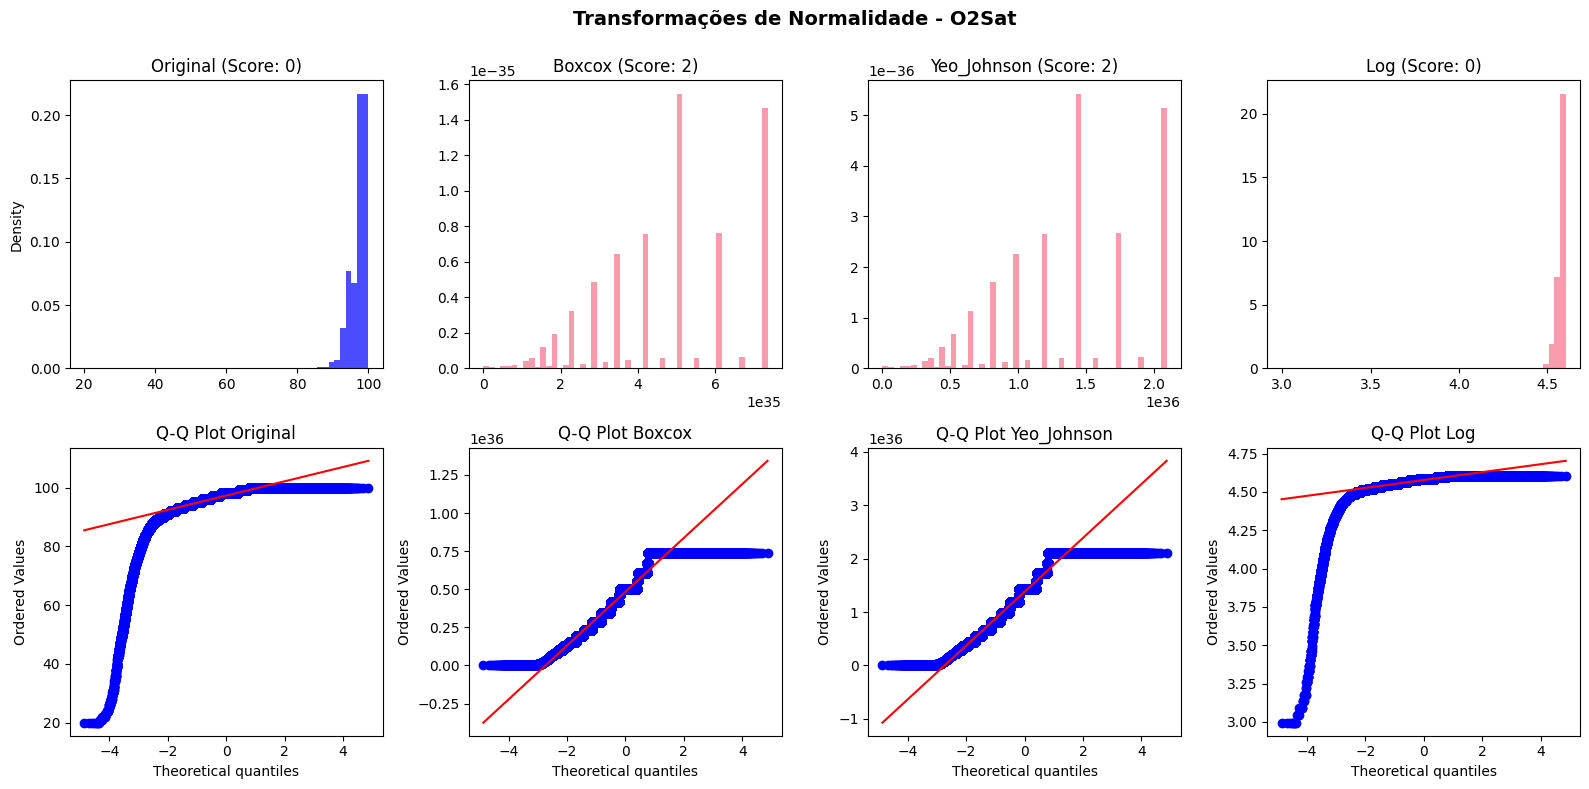

In [112]:
# Troque o nome da variável abaixo e execute a célula para ver os Plots

column_name = 'O2Sat'  # Exemplo: 'O2Sat', 'BUN', 'WBC', 'Hour', etc.
hour_results = validate_normality_transformations(
    data=X_train_fe[column_name], 
    column_name=column_name,
    sample_size=len(X_train_fe),  # Usar todos os dados
    plot_results=True
)

#### 6.1.4 Aplicando as Transformações e Padronizando

Aqui apenas aplicamos as mudanças dessa etapa. 

Por hora usaremos o StandardScaler para padronizar pois queremos preservar outliers e seu impacto até o momento e essa transformação
funciona bem para *features* que estão em unidades e escalas diferentes.

Além disso, a escala não será aplicada em features que são categóricas (por não haver necessidade) e nem
em variáveis de tempo a fim de preservar a intuição inicial do problema que é o tempo ter maior influência na predição.

Outras abordagens possíveis:
 - SVM/Logistic: Usar StandardScaler
 - Neural Networks: Usar MinMax para manter no intervalo [0,1] ou outro intervalo regular
 - Diminuir influência de outliers: RobustScaler

In [109]:
# Estado atual do dataset nesse ponto
print(X_train_fe.head())

   Hour     HR  O2Sat       Temp        DBP  Resp        BUN        WBC  \
0    32   87.0   98.0  37.000000  49.000000  16.0  23.029861  11.539392   
1    16  114.0  100.0  36.940000  52.337797  20.0  21.368639  13.287783   
2    29   93.0   93.0  37.053491  61.000000  19.0  26.098248  12.112435   
3     6  104.0   96.0  38.200000  56.000000  18.0  22.549949  12.642132   
4    41   80.0   99.0  36.992742  55.000000  17.0  25.683570  11.032947   

    Platelets  Gender  Unit1  Unit2  HospAdmTime  ICULOS  Pressure_Unified  \
0  198.297293     0.0    0.0    1.0       -64.69    33.0            83.100   
1  201.370434     0.0    1.0    0.0        -0.03    17.0            83.469   
2  190.559233     1.0    0.0    1.0      -177.25    32.0            89.900   
3  191.116526     1.0    0.0    1.0       -23.51     7.0            84.700   
4  198.269082     0.0    1.0    0.0       -64.40    42.0           104.800   

   Critical_Risk_Window  Time_Category  
0                     0              1 

In [114]:

X_train_transformed = X_train_fe.copy()

columns_to_transform = {var_name: all_normality_results[var_name]['best_transformation'] 
                        for var_name in all_normality_results.keys() 
                        if all_normality_results[var_name]['best_transformation'] != 'Original'}

# Variáveis excluídas da normalização após visualização no Q-Q plot
# (distribuição bimodal ou outras características que não se beneficiam de normalização)
columns_to_transform.pop('Hour', None) # preservar tempo original
columns_to_transform.pop('ICULOS', None) # preservar tempo original
columns_to_transform.pop('O2Sat', None) # distribuição multimodal

# Aplicando a normalização
if columns_to_transform:
    print(f"\nNormalizando as seguintes variáveis: {columns_to_transform}")
    for col, transform_type in columns_to_transform.items():

        data = X_train_fe[col]
        var_name = col
        transform_type = transform_type.lower()

        if transform_type == 'log' and (data > 0).all():
            X_train_transformed[var_name] = np.log(X_train_fe[var_name].replace(0, np.nan))
            
        elif transform_type == 'sqrt' and (data >= 0).all():
            X_train_transformed[var_name] = np.sqrt(X_train_fe[var_name])
            
        elif transform_type == 'boxcox' and (data > 0).all():
            transformed_data, lambda_val = boxcox(data)
            X_train_transformed.loc[data.index, var_name] = transformed_data
            
        elif transform_type == 'yeo_johnson':
            pt = PowerTransformer(method='yeo-johnson', standardize=False)
            transformed_data = pt.fit_transform(data.values.reshape(-1, 1)).flatten()
            X_train_transformed.loc[data.index, var_name] = transformed_data
    
# Dataset após transformações gaussianas
print(X_train_transformed.head())


Normalizando as seguintes variáveis: {'DBP': 'Log', 'Resp': 'Sqrt', 'BUN': 'Yeo_Johnson', 'WBC': 'Boxcox'}
   Hour     HR  O2Sat       Temp       DBP      Resp       BUN       WBC  \
0    32   87.0   98.0  37.000000  3.891820  4.000000  5.882295  3.611720   
1    16  114.0  100.0  36.940000  3.957719  4.472136  5.664192  3.912217   
2    29   93.0   93.0  37.053491  4.110874  4.358899  6.260822  3.713520   
3     6  104.0   96.0  38.200000  4.025352  4.242641  5.820315  3.804664   
4    41   80.0   99.0  36.992742  4.007333  4.123106  6.211342  3.518765   

    Platelets  Gender  Unit1  Unit2  HospAdmTime  ICULOS  Pressure_Unified  \
0  198.297293     0.0    0.0    1.0       -64.69    33.0            83.100   
1  201.370434     0.0    1.0    0.0        -0.03    17.0            83.469   
2  190.559233     1.0    0.0    1.0      -177.25    32.0            89.900   
3  191.116526     1.0    0.0    1.0       -23.51     7.0            84.700   
4  198.269082     0.0    1.0    0.0       -64

In [116]:
# Padronização
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

X_train_scaled = X_train_transformed.copy()

# Aplicar para todas as variáveis de dados clínicos que foram preservados até agora
# Exclui: variáveis de tempo e categóricas (One-Hot Encoded)  
columns_to_scale = ['HR', 'O2Sat', 'Temp', 'DBP', 'Resp', 'BUN', 'WBC', 'Platelets', 'Pressure_Unified']

# StandardScaler (Z-Score) - Mais comum
scaler_standard = StandardScaler()
scaled_columns = pd.DataFrame(
    scaler_standard.fit_transform(X_train_transformed[columns_to_scale]),
    columns=columns_to_scale,
    index=X_train_transformed.index
)

X_train_scaled.update(scaled_columns)

# Estado final do dataset após padronização
print(X_train_scaled.head())


   Hour        HR     O2Sat      Temp       DBP      Resp       BUN       WBC  \
0    32  0.150030  0.258944  0.087663 -1.118286 -0.520987 -0.114361  0.182238   
1    16  1.769803  0.978068 -0.033352 -0.791981  0.349546 -0.406008  1.044907   
2    29  0.509979 -1.538866  0.195551 -0.033613  0.140758  0.391805  0.474485   
3     6  1.169887 -0.460180  2.507962 -0.457088 -0.073601 -0.197241  0.736143   
4    41 -0.269912  0.618506  0.073025 -0.546309 -0.294002  0.325640 -0.084621   

   Platelets  Gender  Unit1  Unit2  HospAdmTime  ICULOS  Pressure_Unified  \
0   0.063513     0.0    0.0    1.0       -64.69    33.0         -0.697808   
1   0.164413     0.0    1.0    0.0        -0.03    17.0         -0.675300   
2  -0.190549     1.0    0.0    1.0      -177.25    32.0         -0.283014   
3  -0.172252     1.0    0.0    1.0       -23.51     7.0         -0.600210   
4   0.062587     0.0    1.0    0.0       -64.40    42.0          0.625874   

   Critical_Risk_Window  Time_Category  
0        

### 6.2 Balanceamento de Classes

Implementação de técnicas para lidar com o severo desbalanceamento entre classes (98.2% vs 1.8%).

**Técnicas a Comparar**:

1. **Undersampling**: Reduz classe majoritária (não-sepse)
   - **RandomUnderSampler**: Remoção aleatória
   - **TomekLinks**: Remove pontos próximos à fronteira
   - **EditedNearestNeighbors**: Remove amostras mal classificadas

2. **Oversampling**: Aumenta classe minoritária (sepse)  
   - **RandomOverSampler**: Duplicação aleatória
   - **SMOTE**: Synthetic Minority Oversampling
   - **ADASYN**: Adaptive Synthetic Sampling

3. **Métodos Híbridos**: Combinam ambos
   - **SMOTETomek**: SMOTE + remoção Tomek Links
   - **SMOTEENN**: SMOTE + Edited Nearest Neighbors

**Vantagens do Undersampling para Sepsis**:
- **Preserva qualidade** dos dados reais de sepse
- **Reduz tempo computacional** (menos dados)
- **Evita overfitting** em dados sintéticos
- **Mantém características** clínicas importantes

#### 6.2.1 Análise de Estratégias de Balanceamento

Comparação de diferentes abordagens: oversampling, undersampling e métodos combinados

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import time

class_counts = y_train_fe.value_counts().sort_index()
class_props = y_train_fe.value_counts(normalize=True).sort_index()
imbalance_ratio = class_counts[0] / class_counts[1]

# Criar amostra estratificada de 10% para acelerar análise
sample_size = 0.1
X_sample, _, y_sample, _ = train_test_split(
    X_train_scaled, y_train_cleaned, 
    test_size=1-sample_size, 
    random_state=42, 
    stratify=y_train_cleaned
)



# Configurar técnicas de balanceamento
techniques = {
    'RandomUnderSampler': RandomUnderSampler(random_state=42),
    'TomekLinks': TomekLinks(),
    'EditedNearestNeighbours': EditedNearestNeighbours(),
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42)
}

# Modelo para avaliação rápida
rf_eval = RandomForestClassifier(n_estimators=30, random_state=42, n_jobs=-1)

# Testar cada técnica na amostra
balancing_results = []
for name, technique in techniques.items():
    try:
        start_time = time.time()
        X_balanced, y_balanced = technique.fit_resample(X_sample, y_sample)
        
        # Avaliação com cross-validation
        cv_scores = cross_val_score(rf_eval, X_balanced, y_balanced, 
                                  cv=3, scoring='f1', n_jobs=-1)
        
        execution_time = time.time() - start_time
        class_dist = pd.Series(y_balanced).value_counts().sort_index()
        print(f'Execution time for {name}: {execution_time:.4f} seconds')

        balancing_results.append({
            'technique': name,
            'f1_score': cv_scores.mean(),
            'f1_std': cv_scores.std(),
            'final_samples': len(X_balanced),
            'class_0': class_dist[0],
            'class_1': class_dist[1],
            'time_seconds': execution_time
        })
        
    except Exception as e:
        continue

# Ordenar resultados por F1-score
balancing_results.sort(key=lambda x: x['f1_score'], reverse=True)

# Aplicar melhor técnica no dataset completo
if balancing_results:
    best_technique_name = balancing_results[0]['technique']
    best_technique = techniques[best_technique_name]
    
    # Aplicar no dataset completo
    X_train_balanced, y_train_balanced = best_technique.fit_resample(X_train_scaled, y_train_cleaned)

Execution time for RandomUnderSampler: 10.6568 seconds
Execution time for TomekLinks: 13.5812 seconds
Execution time for EditedNearestNeighbours: 12.6360 seconds
Execution time for RandomOverSampler: 6.3757 seconds
Execution time for SMOTE: 6.8890 seconds
Execution time for ADASYN: 6.6832 seconds
Execution time for SMOTETomek: 37.3137 seconds
Execution time for SMOTEENN: 36.4313 seconds


In [128]:
# Exibir resultados da análise de balanceamento
if balancing_results:
    results_df = pd.DataFrame(balancing_results)
    results_df = results_df.sort_values('f1_score', ascending=False)
    results_df['rank'] = range(1, len(results_df) + 1)
    
    
    # Mostrar distribuição original
    original_counts = y_sample.value_counts().sort_index()
    original_props = original_counts / original_counts.sum()
    
    # Mostrar ranking das técnicas
    print(f"\nRanking das Técnicas (F1-Score):")
    for i, row in results_df.iterrows():
        print(f"   {row['rank']}º {row['technique']}: {row['f1_score']:.4f}")
    
    # Mostrar comparação final
    final_counts = pd.Series(y_train_balanced).value_counts().sort_index()
    final_props = final_counts / final_counts.sum()
    final_ratio = final_counts[0] / final_counts[1] if len(final_counts) > 1 else 1
    
    print(f"\nMelhor Técnica Aplicada: {best_technique_name}")
    print(f"   Distribuição Final:")
    print(f"   Classe 0 (Sem Sepse): {final_counts[0]:,} ({final_props[0]:.1%})")
    print(f"   Classe 1 (Com Sepse): {final_counts[1]:,} ({final_props[1]:.1%})")
    print(f"   Nova Razão: {final_ratio:.1f}:1")
    print(f"   Tamanho do Dataset: {len(y_train_balanced):,} registros")
    
    # Mostra mudanças percentuais
    prop_change_0 = ((final_props[0] - original_props[0]) / original_props[0]) * 100
    prop_change_1 = ((final_props[1] - original_props[1]) / original_props[1]) * 100
    
    print(f"\nMudanças na Distribuição:")
    print(f"   Classe 0: {prop_change_0:+.1f}%")
    print(f"   Classe 1: {prop_change_1:+.1f}%")
    
    
    # Mostrar DataFrame com todos os resultados
    print("\nTabela Completa dos Resultados:")
    display(results_df[['rank', 'technique', 'f1_score']].round(4))
    
else:
    print("Nenhum resultado de balanceamento encontrado")


Ranking das Técnicas (F1-Score):
   1º RandomOverSampler: 0.9994
   2º SMOTEENN: 0.9898
   3º SMOTETomek: 0.9887
   4º SMOTE: 0.9886
   5º ADASYN: 0.9392
   6º RandomUnderSampler: 0.7016
   7º EditedNearestNeighbours: 0.0347
   8º TomekLinks: 0.0162

Melhor Técnica Aplicada: RandomOverSampler
   Distribuição Final:
   Classe 0 (Sem Sepse): 1,187,303 (50.0%)
   Classe 1 (Com Sepse): 1,187,303 (50.0%)
   Nova Razão: 1.0:1
   Tamanho do Dataset: 2,374,606 registros

Mudanças na Distribuição:
   Classe 0: -49.1%
   Classe 1: +2662.0%

Tabela Completa dos Resultados:


,rank,technique,f1_score
0,1,RandomOverSampler,0.9994
1,2,SMOTEENN,0.9898
2,3,SMOTETomek,0.9887
3,4,SMOTE,0.9886
4,5,ADASYN,0.9392
5,6,RandomUnderSampler,0.7016
6,7,EditedNearestNeighbours,0.0347
7,8,TomekLinks,0.0162


#### 6.2.2 Discussão dos Resultados da Análise de Balanceamento

Aplicação da técnica de balanceamento selecionada com base na análise comparativa.

**Como output comparação obtivemos**:

    - Melhor Técnica: RandomOverSampler
    - F1-Score: 0,9994 (excelente performance)
    - Resultado: Dataset perfeitamente balanceado (50%/50%)
    - Tamanho final: 2.374.606 registros

Ranking das Técnicas (F1-Score):
* RandomOverSampler (0,9994) 
* SMOTEENN (0,9898) 
* SMOTETomek (0,9887)
* SMOTE (0,9886) 
* ADASYN (0,9392) 
* RandomUnderSampler (0,7016)
* EditedNearestNeighbours (0,0347) 
* TomekLinks (0,0162) 

No entanto, perceba que a maioria dessas técnicas tem um desempenho muito ruim, seja por under ou overfitting:
- RandomOverSampler: Simplesmente duplica aleatoriamente os elementos da classe minoritária até equilibrar. Então o modelo acaba por memorizar os exemplos e isso fica mais evidente quando usamos uma validação cruzada, que um mesmo exemplo pode estar no treino e no teste ao mesmo tempo devido à duplicaçao.
- SMOTE e derivados: Cria exemplos entre vizinhos mais próximos da mesma classe. Mesmo problema do RandomOverSampler além de acrescentar casos que podem não ser fieis à realidade
- ADASYN: Minimiza o problema do OverSampler tentando aprimorar a fronteira de decisão mas possui o mesmo problema dos demais de criam dados sintéticos.
- EditedNearesNeighbours: Remove pontos que possivelmente serviriam para delimitar a fronteira de decisão, o resultado é um modelo que aprende errado e escolhe errado na maioria das vezes
- TomekLinks: Mesmo problema do ENN por remover justamente os casos que serviriam para o modelo onde separar cada classe.

Por causa do severo desbalanceamento, a maioria das técnicas sofre com alta variância, porquê o modelo decora os exemplos se tentarmos criar exemplos sintéticos (pois são muitos), ou alto viés, porquê remove-se justamente os que serviriam para generalizar.

Considerando o grande número de instâncias (~1.2M) e um desbalanceamento de 1:54 aproximadamente. A estratégia que demonstra-se mais confiável é a de remoção de instãncias da classe majoritária aleatoriamente, porém não tanto ao ponto de igualar as proporções pois perderíamos muitos dados. Devemos visar uma remoção que tente diminuir só um pouco a desproporção e deixar que o modelo aprenda com o dataset praticamente do jeito que está. 


#### 6.2.3 Aplicação de Under Sampling Simples

Pensando em ainda manter o desbalanceamento para não perdemos muitos dados, porém diminuir o suficiente para aumentar a capacidade de generalização do modelo. Vamos optar por reduzir o tamanho da classe majoritária em 30% como primeira opção.

In [133]:
# Implementação de undersampling inteligente baseado em proporcionalidade
# Separar classes para manipulação independente
minority_class = X_train_scaled[y_train_cleaned == 1]
majority_class = X_train_scaled[y_train_cleaned == 0]

minority_class_target = y_train_cleaned[y_train_cleaned == 1]
majority_class_target = y_train_cleaned[y_train_cleaned == 0]

print(f"Distribuição original:")
print(f"Classe minoritária (sepse): {len(minority_class):,}")
print(f"Classe majoritária (não-sepse): {len(majority_class):,}")
print(f"Razão original: {len(majority_class) / len(minority_class):.1f}:1")

# Redução da classe majoritária preservando o desbalanceamento evitando excesso
n_samples_majority = int(0.7 * len(majority_class))

# Amostragem estratificada por grupos clínicos relevantes se disponível
# Caso contrário, amostragem aleatória com seed para reproducibilidade
majority_class_subset = majority_class.sample(n=n_samples_majority, random_state=42)
majority_class_target_subset = majority_class_target.loc[majority_class_subset.index]

# Combinar classes balanceadas
X_train_undersampled = pd.concat([majority_class_subset, minority_class])
y_train_undersampled = pd.concat([majority_class_target_subset, minority_class_target])

# Embaralhar o dataset final para evitar bias de ordenação
shuffle_idx = np.random.RandomState(42).permutation(len(X_train_undersampled))
X_train_undersampled = X_train_undersampled.iloc[shuffle_idx].reset_index(drop=True)
y_train_undersampled = y_train_undersampled.iloc[shuffle_idx].reset_index(drop=True)

# Validação dos resultados
final_counts = y_train_undersampled.value_counts().sort_index()
final_props = final_counts / final_counts.sum()
final_ratio = final_counts[0] / final_counts[1]

print(f"\nResultados do undersampling:")
print(f"Classe 0 (não-sepse): {final_counts[0]:,} ({final_props[0]:.1%})")
print(f"Classe 1 (sepse): {final_counts[1]:,} ({final_props[1]:.1%})")
print(f"Nova razão: {final_ratio:.1f}:1")
print(f"Tamanho total do dataset: {len(X_train_undersampled):,}")
print(f"Redução do dataset original: {((len(X_train_transformed) - len(X_train_undersampled)) / len(X_train_transformed)) * 100:.1f}%")


print('\n',X_train_undersampled.head())

Distribuição original:
Classe minoritária (sepse): 21,894
Classe majoritária (não-sepse): 1,187,303
Razão original: 54.2:1

Resultados do undersampling:
Classe 0 (não-sepse): 831,112 (97.4%)
Classe 1 (sepse): 21,894 (2.6%)
Nova razão: 38.0:1
Tamanho total do dataset: 853,006
Redução do dataset original: 29.5%

    Hour        HR     O2Sat      Temp       DBP      Resp       BUN       WBC  \
0     8 -1.109794 -0.460180 -0.936182  2.159974 -0.073601 -0.277186 -1.393580   
1    47  0.569971 -2.437770  0.173477  0.430943 -0.997324  0.309171  0.245616   
2     6  0.150030  0.978068  0.016114 -0.198683 -0.073601 -0.310739  0.121368   
3    39 -0.269912  0.258944  0.289355 -0.115460  0.752015  0.298591 -0.003965   
4   127  0.569971 -0.460180  0.007012  1.055050 -0.520987  0.702140 -0.180545   

   Platelets  Gender  Unit1  Unit2  HospAdmTime  ICULOS  Pressure_Unified  \
0   0.450716     1.0    1.0    0.0       -12.06     9.0          3.657535   
1  -0.275108     1.0    1.0    0.0        -0.0

## 7. Criação dos Datasets Finais e Export

Verificação final da qualidade e consistência dos dados preparados, seguida do salvamento dos datasets processados.

#### 7.1 Criação do Dataset Final  + Dataset Head

In [135]:
# Criação dos datasets finais de treino
X_train_final = X_train_undersampled.copy()
y_train_final = y_train_undersampled.copy()

# Criação do dataset final unificado (features + target)
dataset_final = X_train_final
dataset_final['SepsisLabel'] = y_train_final

# Visualização das primeiras linhas do dataset final unificado
print("Primeiras 5 linhas do dataset final (features + target):")
print(dataset_final.head())

Primeiras 5 linhas do dataset final (features + target):
   Hour        HR     O2Sat      Temp       DBP      Resp       BUN       WBC  \
0     8 -1.109794 -0.460180 -0.936182  2.159974 -0.073601 -0.277186 -1.393580   
1    47  0.569971 -2.437770  0.173477  0.430943 -0.997324  0.309171  0.245616   
2     6  0.150030  0.978068  0.016114 -0.198683 -0.073601 -0.310739  0.121368   
3    39 -0.269912  0.258944  0.289355 -0.115460  0.752015  0.298591 -0.003965   
4   127  0.569971 -0.460180  0.007012  1.055050 -0.520987  0.702140 -0.180545   

   Platelets  Gender  Unit1  Unit2  HospAdmTime  ICULOS  Pressure_Unified  \
0   0.450716     1.0    1.0    0.0       -12.06     9.0          3.657535   
1  -0.275108     1.0    1.0    0.0        -0.05    48.0          0.534375   
2  -0.191266     1.0    1.0    0.0        -0.02     7.0         -0.783207   
3  -3.152920     0.0    0.0    1.0       -75.85    43.0          0.546575   
4   0.030433     0.0    0.0    1.0        -0.03   128.0          1.6201

#### 7.2 Estatísticas do Dataset final 

In [136]:
# Shapes e tipos
print(f"Shape X_train_final: {X_train_final.shape}")
print(f"Shape y_train_final: {y_train_final.shape}")
print(f"Tipos de dados em X_train_final: {X_train_final.dtypes.value_counts().to_dict()}")
print(f"Tipo de dados em y_train_final: {y_train_final.dtype}")

# Verificar valores ausentes
missing_final = X_train_final.isnull().sum().sum()
print(f"Total de valores ausentes: {missing_final}")

# Resumo final do pipeline
print(f"\nResumo Final do Pipeline de Preparação de Dados:")
print(f"Dataset original: {len(X_train):,} amostras")
print(f"Dataset final: {len(dataset_final):,} amostras")
print(f"Redução: {((len(X_train) - len(dataset_final)) / len(X_train)) * 100:.1f}%")

# Distribuição da variável target
target_distribution = y_train_final.value_counts().sort_index()
target_proportions = y_train_final.value_counts(normalize=True).sort_index()
print(f"Distribuição da variável target:")
print(f"  Classe 0: {target_distribution[0]:,} ({target_proportions[0]:.1%})")
print(f"  Classe 1: {target_distribution[1]:,} ({target_proportions[1]:.1%})")

# Estatísticas descritivas básicas
print(f"\nEstatísticas Descritivas (primeiras 5 variáveis):")
print(X_train_final.iloc[:, :5].describe().round(2))



Shape X_train_final: (853006, 18)
Shape y_train_final: (853006,)
Tipos de dados em X_train_final: {dtype('float64'): 15, dtype('int64'): 3}
Tipo de dados em y_train_final: float64
Total de valores ausentes: 0

Resumo Final do Pipeline de Preparação de Dados:
Dataset original: 1,241,768 amostras
Dataset final: 853,006 amostras
Redução: 31.3%
Distribuição da variável target:
  Classe 0: 831,112 (97.4%)
  Classe 1: 21,894 (2.6%)

Estatísticas Descritivas (primeiras 5 variáveis):
            Hour         HR      O2Sat       Temp        DBP
count  853006.00  853006.00  853006.00  853006.00  853006.00
mean       26.03       0.00      -0.00       0.00      -0.00
std        29.60       1.00       1.00       1.00       1.00
min         0.00      -3.87     -27.79     -28.15     -12.71
25%         9.00      -0.69      -0.46      -0.43      -0.63
50%        20.00      -0.06       0.26      -0.03      -0.03
75%        33.00       0.57       0.62       0.42       0.59
max       335.00      11.73    

#### 7.3 Exportação Para CSV

In [ ]:
# Exportação do dataset final unificado para CSV
output_path = "dataset_sepsis_train_prepared.csv"
print(f"Dataset final exportado para: {output_path}")

dataset_final.to_csv(output_path, index=False)



Dataset final exportado para: dataset_sepsis_train_prepared.csv
Tamanho do arquivo: 117.1 MB
